# Bayesian Optimization Pythia Tune using Ax - Reduced Parameters
> Created: June 4 2024 AAK, Harrison B. Prosper

## Running the notebook
All code and program dependencies such as pythia, rivet, hepmc, Ax are preinstalled on the docker image `alialkadhim/pythia_sbi_tune:latest`. Here is how to install the image and run this notebook:

```
git clone https://github.com/AliAlkadhim/Pythia8_SBI_Tune.git
```
Then,
```
cd Pythia8_SBI_Tune/code/BayesOpt
bash docker_run.sh
```

Then, inside the docker container, do

```
jupyter-lab --ip 0.0.0.0 --port 8889 --allow-root &
```

Now copy and paste the link displayed at the bottom of the terminal to your browser

----

This notebook is an extension for `BO_TuneAx_all_params.ipynb` and it performs Bayesian Optimizaion using [Ax](https://github.com/facebook/Ax) of the Lund string model parameters $a$ and $b$ that appear in the fragmentation function

$$
f_{\text{Lund}}(z) \propto \frac{(1-z)^a}{z} \exp \left(-\frac{b m_{\perp}^2}{z}\right)
$$

which are referred to as `StringZ:aLund` and `StringZ:bLund` in pythia8, respectively.

We use the data from `ALEPH_1996_S3486095` from the paper ["Studies of quantum chromodynamics with the ALEPH detector"](https://www.sciencedirect.com/science/article/pii/S0370157397000458)


## Key Observations
The default values of these parameters in pythia is due to the [Monash Tune](https://arxiv.org/pdf/1404.5630.pdf). Other papers have corroborated the results of that tune and attained similar values for some of the parameters. Therefore, when performing the Bayesian Optimization, we want to take that into account by forcing the algorithm to sample the Monash tune point. Observe how with few number of iterations, while forcing the sobol quasirandom sampling to explore the Monash tune, we will most likely end up with the Monash tune as the best-fit point. However, when we increase the number of iterations, we arrive at a tune that is slightly different than the Monash tune.

## Diferences from the previous notebook
This notebook differs from the previous notebook, `BO_TuneAx_all_params.ipynb`, in the following ways:

1. Instead of using the following test statistic:

$$
    \lambda(X; \theta) = \sqrt{\frac{1}{N}\sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2}, \tag{1}
$$


we will use a linear sum of $\chi^2$ variates:
$$
    \lambda(X; \theta) = \sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2, \tag{2}
$$

where $N$ is the total number of bins summed over histograms and $\delta_i^2$ is the sum of the variances associated with the data $D_i$ and the theoretical prediction $T_i$ with the latter obtained via Monte Carlo simulation.

The reason is that the peculiar objective function in Eq. (1) is designed for use in a neural network, so we cannot correctly interpret the minos errors as confidence intervals because the objective function doesn't have a $\chi^2$ distribution. On the other hand using Eq. (2) we can interpret this as a $\chi^2$ function for which the usual rules can be applied to derive the errors.


2. We keep fixed all the parameters which are not well determined to the values we found in `BO_TuneAx_all_params.ipynb`. We keep the parameters which are well-determined floating.

Well-determined parameters: [sigma, aExtraSQuark, enhancedFraction, probStoUD, probQQtoQ, probSQtoQQ, alphaSvalue, pTmin]

not well-determined parameters: [aLund, bLund, rFactC, rFactB, aExtraDiquark, enhancedWidth, ProbQQ1toQQ0]

In addition to floating the parameters which are well-determined, we also float $a$ and $b$ again. Therefore:

**floating parameters**: [ aLund, bLund, sigma, aExtraSQuark, enhancedFraction, probStoUD, probQQtoQ, probSQtoQQ, alphaSvalue, pTmin ]

**fixed parameters**: [rFactC, rFactB, aExtraDiquark, enhancedWidth, ProbQQ1toQQ0]

3. We remove histograms that have large discrepancies between theory and data in `BO_TuneAx_all_params.ipynb`, as these histograms could be causing biasing. These observables are just not well modeled by pythia. These observables (histograms) are: ['d35-x01-y01', 'd36-x01-y01','d39-x01-y01', 'd40-x01-y01']

----

## Considererations for Data and Effective counts
Notice (unfortunately) that the total effective counts for every histogram is different! This is a huge complication because, in principle, we would need to generate different numbers of events for every histogram. But, as is true of much of what we do in science, we should make some simplifying assumptions to reduce to complexity of the problem. 

**Assumptions**

  1. Since we are not given correlation matrices for the measured cross sections, we assume that the bin-by-bin cross section measurements are conditionally independent: given fixed values of the tune parameters the measured cross sections are statistically independent.
  2. The counts per bin are Poisson-distributed and the cross sections are just scaled values of the counts.  We can, therefore, compute the effective count in each bin using the following *ansatz*
\begin{align}
    n_i & = k_i \sigma_i,\\
    \sqrt{n_i} & = k_i \delta \sigma_i \quad \text{and, therefore, }\\
    n_i & = \left( \frac{\sigma_i}{\delta\sigma_i} \right)^2 ,
\end{align}
where $\sigma_i \pm \delta\sigma_i$ is the measured cross section in bin $i$ and $k_i$, the *effective integrated luminosity*, is the product $\epsilon_i {\cal L}$ of the efficiency times acceptance, $\epsilon_i$, and  the integrated luminosity ${\cal L}$. The total effective count for a histogram is then just $n = \sum_{i} n_i$.

Therefore, for each tune parameter point, a sufficiently large sample of simulated events will result in histograms that serve both as the predictions as well as the basis for simulating events counts in all the simulated "observed" histograms. Given our assumptions, we can write down an approximation of the statistical model, $p(X | \theta)$, where $X$ are *potentially observable* counts and $\theta$ are the tune parameters. With the assumptions above, the statistical model for the $\texttt{ALEPH}$ data can be approximated as a product of either gamma or Gaussian densities depending on the size of the effective bin counts. We see that about 300,000 events need to be simulated per point in order to match the statistical precision of the data.

## .yoda format
The .yoda histograms for the data look like:

```
# xval	 xerr-	 xerr+	 yval	 yerr-	 yerr+
```
`xval` is the bin center, while `yval` is the height of the bin center. `xerr-=xerr+` is the positive and uncertainties in the bin center location, and `yerr-=yerr+` is the uncertainty in the height.

The data recorded is the cross section. so let's call that cross section in bin i $\hat{\sigma}_i^{Data} =yval$ and the uncertainty in bin i $\Delta^{Data}_i = yerr-$ . 


while the simulation histograms look like:
```
xlow	 xhigh	 sumw	 sumw2	 sumwx	 sumwx2	 numEntries
```

`xlow` is the left edge and `xhigh` is the right edge for a bin $i$. `sumw` is the sum of weights per bin $i$ $sumw^{bin, i} \sum_{k=1}^{N_{counts \ in \ bin \ i}} w_k^{bin \ i}$ and `sumw2` is sum of weights squared $sumw2^{bin \ i}=\sum_{k=1}^{N_{counts \ in \ bin \ i}} (w_k^{bin \ i})^2$ . To convert to differential cross section we divide by the bin widths, i.e. we calculate $\Delta x = xhigh-xlow$ and divide $\hat{\sigma}_i^{MC} = sumw/\Delta x$ and $sumw2/\Delta x ^2$ and $sumwx/\Delta x$ and $sumwx2/Delta x^2$ . Then the MC error for the cross section per bin is $\Delta_i^{MC} =\sqrt{sumw2/\Delta x ^2}$ 

We can write the effective count can be as
$$\frac{\sqrt{\sum_i w_i^2}}{\sum_i w_i}=\frac{1}{\sqrt{N_{e f f}}}$$
So 
$$N_{eff,\ i} = \left( \frac{\sum_i w_i }{\sqrt{\sum_i w_i^2 } } \right)^2 = \left( \frac{\sum_i w_i}{\Delta_{i, MC}} \right)^2$$
Therefore the scale factor per bin is

$$K_i = \frac{\sum_i w_i}{\sum_i w_i^2 }= \frac{\sum_i w_i}{\Delta_{i,MC}^2}$$

------

In [118]:
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import importlib

from bayes_opt import BayesianOptimization, UtilityFunction 


from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.core.observation import ObservationFeatures

import torch
init_notebook_plotting()
# import plotly.io as pio
# pio.renderers.default = "jupyterlab"


#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

[INFO 06-05 18:40:32] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 06-05 18:40:32] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


In [31]:
BAYES_OPT=False
AX=True

In [2]:
N_ITER = 120
best_param_filename_120 = f"best_parameters/all_parameters_Niter_{N_ITER}.csv"
best_parameters_120 = pd.read_csv(best_param_filename_120)
best_parameters_120

Unnamed: 0    aLund     bLund   rFactC    rFactB  aExtraSQuark  \
0           0  0.75248  1.049841  1.38034  0.819206           0.0   

   aExtraDiquark     sigma  enhancedFraction  enhancedWidth  ProbStoUD  \
0       0.931775  0.316637               0.0       1.939937   0.217093   

   probQQtoQ  probSQtoQQ  ProbQQ1toQQ0  alphaSvalue     pTmin  
0   0.104321    0.949422      0.164353      0.13793  0.495941

In [66]:
float(best_parameters_120['rFactC'])

/tmp/ipykernel_56/2751996330.py:1: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



1.380340215435916

In [121]:
# FLOATING PARAAMS: 
# aLund, 
# bLund, 
# sigma, 
# aExtraSQuark, 
# enhancedFraction, 
# probStoUD, 
# probQQtoQ, 
# probSQtoQQ, 
# alphaSvalue, 
# pTmin

def make_pythia_card(aLund, 
                     bLund,
                    aExtraSQuark,
                    sigma,
                    enhancedFraction,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    alphaSvalue,
                    pTmin):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 250          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")
        f.write(f"StringZ:rFactC = {float(best_parameters_120['rFactC'])}\n\n")
        f.write(f"StringZ:rFactB = {float(best_parameters_120['rFactB'])}\n\n")
        f.write(f"StringZ:aExtraSQuark = {aExtraSQuark}\n\n")
        f.write(f"StringZ:aExtraDiquark = {float(best_parameters_120['aExtraDiquark'])}\n\n")
        f.write(f"StringPT:sigma = {sigma}\n\n")
        f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        f.write(f"StringPT:enhancedWidth = {float(best_parameters_120['enhancedWidth'])}\n\n")
        f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        f.write(f"StringFlav:ProbQQ1toQQ0 = {float(best_parameters_120['ProbQQ1toQQ0'])}\n\n")
        f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        


def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

In [122]:
dfdata, dfsims, generated_indices = get_data()
print('DATA DATAFRAME')
print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
print('FIRST SIM DATAFRAME')
print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

data_keys, mc_keys = get_hist_names(dfdata)

filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

print(f'length of filtered_data_keys = {len(filtered_data_keys)}')

[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.37it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh    sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.648  0.005184  0.002320  0.001849        81.0
1  0.005  0.010   4.152  0.033216  0.032963  0.053986       519.0
2  0.010  0.015   7.552  0.060416  0.095305  0.243808       944.0
3  0.015  0.020   9.856  0.078848  0.173107  0.612117      1232.0
4  0.020  0.025  10.248  0.081984  0.231000  1.045824      1281.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH

In [123]:
def reduce_filtered_keys(filtered_data_keys, filtered_mc_keys):
    # Initialize empty list for the reduced keys
    reduced_data_keys = []
    reduced_mc_keys = []
    # List of histogram keys that need to be removed
    hists_to_remove = ['d35-x01-y01', 'd36-x01-y01', 'd39-x01-y01', 'd40-x01-y01']
    
    # Iterate over each data key
    for data_key in filtered_data_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(data_key) for hist_to_remove in hists_to_remove):
            reduced_data_keys.append(data_key)

    for mc_key in filtered_mc_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(mc_key) for hist_to_remove in hists_to_remove):
            reduced_mc_keys.append(mc_key)
            
        
    return reduced_data_keys, reduced_mc_keys

        

In [124]:
reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)
print(reduced_data_keys, reduced_mc_keys)
print(f'length of reduced data keys = {len(reduced_data_keys)}')
print(f'length of reduced mc keys = {len(reduced_mc_keys)}')

['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S3486095/d37-x01-y01',

In [125]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import *

def true_objective_func(aLund, 
                     bLund,
                    aExtraSQuark,
                    sigma,
                    enhancedFraction,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    alphaSvalue,
                    pTmin):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, 
                     bLund,
                    aExtraSQuark,
                    sigma,
                    enhancedFraction,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    alphaSvalue,
                    pTmin)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo

    /media/ali/DATA/TEMP/rm ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    

    #step 3: get generated yoda file histograms in the form of dataframes
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

    #step 4: fileter histograms based on our criteria
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

    #step 4.5: take out bad histograms
    reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)

    
    #step 5: get test statistic at each point
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(reduced_data_keys,
                                         reduced_mc_keys, 
                                         dfdata, 
                                         dfsims[gen_ind], 
                                         which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
    if BAYES_OPT:        
        objective_func = - X0[0]
    else:
        objective_func = X0[0]
    # os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

In [126]:
PARAM_DICT = {
        'StringZ:aLund' : [0.5, 2.0],
        'StringZ:bLund': [0.5, 2.0],
        # 'StringZ:rFactC':[0.0, 2.0],
        # 'StringZ:rFactB': [0., 2.0],
        'StringZ:aExtraSQuark':[0.,2.],
        # 'StringZ:aExtraDiquark':[0.,2.],
        'StringPT:sigma':[0.,1.],
        'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,4.0],
        'StringFlav:ProbStoUD':[0,4.0],
        'StringFlav:probQQtoQ':[0,4.0],
        'StringFlav:probSQtoQQ':[0,4.0],
        # 'StringFlav:ProbQQ1toQQ0':[0,4.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "rFactC": 1.32,
    "rFactB":0.855,
    "aExtraSQuark": 0.0,
    "aExtraDiquark":0.97,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

REDUCED_MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "aExtraSQuark": 0.0,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

ab_tune_Monash_rest = REDUCED_MONASH_DICT.copy()
ab_tune_Monash_rest["aLund"] = 1.1279257649367096
ab_tune_Monash_rest["bLund"] =1.349756967243872
ab_tune_Monash_rest

{'aLund': 1.1279257649367096,
 'bLund': 1.349756967243872,
 'aExtraSQuark': 0.0,
 'sigma': 0.335,
 'enhancedFraction': 0.01,
 'ProbStoUD': 0.217,
 'probQQtoQ': 0.081,
 'probSQtoQQ': 0.915,
 'alphaSvalue': 0.1365,
 'pTmin': 0.5}

In [127]:
ax_client = AxClient()
ax_client.create_experiment(
name="Ax_Tune_Pythia",
        parameters = [
                    {
                        "name": "aLund",
                        "type": "range",
                        "bounds": [0.5, 2.0],
                    }, 
                    {
                        "name": "bLund",
                        "type": "range",
                        "bounds": [0.5, 2.0],
                    },

                    {
                        "name": "aExtraSQuark",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 

                    {
                        "name": "sigma",
                        "type": "range",
                        "bounds": [0.,1.],
                    }, 
                    {
                        "name": "enhancedFraction",
                        "type": "range",
                        "bounds": [0.,1.],
                    }, 

                    {
                        "name": "ProbStoUD",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "probQQtoQ",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "probSQtoQQ",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
   
                    {
                        "name": "alphaSvalue",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0.06,0.25],
                    }, 
                    {
                        "name": "pTmin",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0.1,2.0],
                    }, 
            
                ],
objectives = {"true_objective_func": ObjectiveProperties(minimize=True)},
)

[INFO 06-05 18:41:29] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 06-05 18:41:29] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter aLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-05 18:41:29] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-05 18:41:29] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter aExtraSQuark. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-05 18:41

In [128]:


##########################################
# Sample Monash Tune point
suggest_param, suggest_ind = ax_client.attach_trial(
    parameters=REDUCED_MONASH_DICT
)
ax_client.complete_trial(trial_index=suggest_ind, raw_data=true_objective_func(
        aLund=suggest_param["aLund"], 
        bLund=suggest_param["bLund"],
        aExtraSQuark=suggest_param["aExtraSQuark"],
        sigma=suggest_param["sigma"],
        enhancedFraction=suggest_param["enhancedFraction"],
        ProbStoUD=suggest_param["ProbStoUD"],
        probQQtoQ=suggest_param["probQQtoQ"],
        probSQtoQQ=suggest_param["probSQtoQQ"],
        alphaSvalue=suggest_param["alphaSvalue"],
        pTmin=suggest_param["pTmin"]
))
##########################################
# Sample ab tune point with the rest of the parameters from the Monash tune
suggest_param_ab, suggest_ind_ab = ax_client.attach_trial(
    parameters=ab_tune_Monash_rest
)
ax_client.complete_trial(trial_index=suggest_ind_ab, raw_data=true_objective_func(
        aLund=suggest_param_ab["aLund"], 
        bLund=suggest_param_ab["bLund"],
        aExtraSQuark=suggest_param_ab["aExtraSQuark"],
        sigma=suggest_param_ab["sigma"],
        enhancedFraction=suggest_param_ab["enhancedFraction"],
        ProbStoUD=suggest_param_ab["ProbStoUD"],
        probQQtoQ=suggest_param_ab["probQQtoQ"],
        probSQtoQQ=suggest_param_ab["probSQtoQQ"],
        alphaSvalue=suggest_param_ab["alphaSvalue"],
        pTmin=suggest_param_ab["pTmin"]
))


##########################################
# start main tuning loop
N_ITER = 22
for i in range(N_ITER):
    parameterization, trial_index = ax_client.get_next_trial()
    print(parameterization)
    ax_client.complete_trial(trial_index=trial_index, raw_data=true_objective_func(
        aLund=parameterization["aLund"], 
        bLund=parameterization["bLund"],
        aExtraSQuark=parameterization["aExtraSQuark"],
        sigma=parameterization["sigma"],
        enhancedFraction=parameterization["enhancedFraction"],
        ProbStoUD=parameterization["ProbStoUD"],
        probQQtoQ=parameterization["probQQtoQ"],
        probSQtoQQ=parameterization["probSQtoQQ"],
        alphaSvalue=parameterization["alphaSvalue"],
        pTmin=parameterization["pTmin"]
    ))



[INFO 06-05 18:41:37] ax.core.experiment: Attached custom parameterizations [{'aLund': 0.68, 'bLund': 0.98, 'aExtraSQuark': 0.0, 'sigma': 0.335, 'enhancedFraction': 0.01, 'ProbStoUD': 0.217, 'probQQtoQ': 0.081, 'probSQtoQQ': 0.915, 'alphaSvalue': 0.1365, 'pTmin': 0.5}] as trial 0.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) ins


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:41:39
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:41:39
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:41:39, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.71it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.000000   9.600000  0.042706  0.031659        15.0
1  0.005  0.010  24.000000  19.200001  0.170603  0.250696        30.0
2  0.010  0.015  19.200001  15.360000  0.240477  0.609309        24.0
3  0.015  0.020  13.600000  10.880000  0.234369  0.813772        17.0
4  0.020  0.025  18.400000  14.720000  0.416401  1.891732        23.0


[INFO 06-05 18:41:40] ax.service.ax_client: Completed trial 0 with data: {'true_objective_func': (5679.519525, None)}.
[INFO 06-05 18:41:40] ax.core.experiment: Attached custom parameterizations [{'aLund': 1.127926, 'bLund': 1.349757, 'aExtraSQuark': 0.0, 'sigma': 0.335, 'enhancedFraction': 0.01, 'ProbStoUD': 0.217, 'probQQtoQ': 0.081, 'probSQtoQQ': 0.915, 'alphaSvalue': 0.1365, 'pTmin': 0.5}] as trial 1.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarnin

objective function = 5679.519525051117

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:41:42
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:41:42
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:41:42, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1/2 [00:00<00:00,  7.77it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.58it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.400000   8.320000  0.032495  0.023681        13.0
1  0.005  0.010  16.799999  13.440000  0.127712  0.202432        21.0
2  0.010  0.015  28.799999  23.040001  0.360764  0.913081        36.0
3  0.015  0.020  14.400000  11.520000  0.241998  0.816988        18.0
4  0.020  0.025  15.200000  12.160000  0.340249  1.529695        19.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', 

[INFO 06-05 18:41:43] ax.service.ax_client: Completed trial 1 with data: {'true_objective_func': (12871.380558, None)}.
[INFO 06-05 18:41:43] ax.service.ax_client: Generated new trial 2 with parameters {'aLund': 1.659056, 'bLund': 1.294576, 'aExtraSQuark': 0.160278, 'sigma': 0.216856, 'enhancedFraction': 0.973336, 'ProbStoUD': 1.566714, 'probQQtoQ': 2.66602, 'probSQtoQQ': 1.5898, 'alphaSvalue': 0.113497, 'pTmin': 1.940176} using model Sobol.


objective function = 12871.380558013916
{'aLund': 1.6590561866760254, 'bLund': 1.2945756316184998, 'aExtraSQuark': 0.16027842462062836, 'sigma': 0.2168557196855545, 'enhancedFraction': 0.973335862159729, 'ProbStoUD': 1.566713809967041, 'probQQtoQ': 2.666019916534424, 'probSQtoQQ': 1.5898003578186035, 'alphaSvalue': 0.11349694430828094, 'pTmin': 1.9401755154132843}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              | 

/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:58: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead




 *-------  PYTHIA Process Initialization  --------------------------*
 |                                                                  |
 | We collide e- with e+ at a CM energy of 9.120e+01 GeV            |
 |                                                                  |
 |------------------------------------------------------------------|
 |                                                    |             |
 | Subprocess                                    Code |   Estimated |
 |                                                    |    max (mb) |
 |                                                    |             |
 |------------------------------------------------------------------|
 |                                                    |             |
 | f fbar -> gamma*/Z0                            221 |   4.352e-05 |
 |                                                                  |
 *-------  End PYTHIA Process Initialization -----------------------*

 *-------  PYTHIA 

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:41:46
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:41:46
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:41:46, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.46it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda



[INFO 06-05 18:41:46] ax.service.ax_client: Completed trial 2 with data: {'true_objective_func': (18514.701113, None)}.
[INFO 06-05 18:41:46] ax.service.ax_client: Generated new trial 3 with parameters {'aLund': 1.417259, 'bLund': 1.797418, 'aExtraSQuark': 0.482534, 'sigma': 0.561879, 'enhancedFraction': 0.109348, 'ProbStoUD': 2.002163, 'probQQtoQ': 3.993258, 'probSQtoQQ': 2.883216, 'alphaSvalue': 0.128022, 'pTmin': 1.675373} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ip

DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  31.200001  24.959999  0.089686  0.059543        39.0
1  0.005  0.010  32.000000  25.600000  0.242262  0.377426        40.0
2  0.010  0.015  27.200001  21.760000  0.334261  0.832864        34.0
3  0.015  0.020  19.200001  15.360000  0.337871  1.196948        24.0
4  0.020  0.025  16.000000  12.800000  0.357088  1.602618        20.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:41:48
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:41:49
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:41:49, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.29it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  27.200001  21.76  0.083053  0.058074        34.0
1  0.005  0.010  32.799999  26.24  0.226926  0.325455        41.0
2  0.010  0.015  17.600000  14.08  0.217654  0.544374        22.0
3  0.015  0.020  14.400000  11.52  0.249037  0.867616        18.0
4  0.020  0.025   8.800000   7.04  0.195140  0.868660        11.0
 new data keys ['/REF/AL


[INFO 06-05 18:41:49] ax.service.ax_client: Completed trial 3 with data: {'true_objective_func': (12909.708918, None)}.


objective function = 12909.708917617798


[INFO 06-05 18:41:49] ax.service.ax_client: Generated new trial 4 with parameters {'aLund': 0.739719, 'bLund': 1.668346, 'aExtraSQuark': 0.061984, 'sigma': 0.661638, 'enhancedFraction': 0.06086, 'ProbStoUD': 2.43673, 'probQQtoQ': 0.769986, 'probSQtoQQ': 1.970278, 'alphaSvalue': 0.232262, 'pTmin': 0.994005} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeEr

{'aLund': 0.7397193433716893, 'bLund': 1.6683459016494453, 'aExtraSQuark': 0.06198396719992161, 'sigma': 0.6616383986547589, 'enhancedFraction': 0.06086043640971184, 'ProbStoUD': 2.436729695647955, 'probQQtoQ': 0.7699864320456982, 'probSQtoQQ': 1.9702775664627552, 'alphaSvalue': 0.23226187722757458, 'pTmin': 0.9940054225735365}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:41:51
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:41:51
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:41:51, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.39it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.0   0.00  0.000000  0.000000         0.0
1  0.005  0.010   4.0   3.20  0.030064  0.046756         5.0
2  0.010  0.015   3.2   2.56  0.038332  0.092038         4.0
3  0.015  0.020   7.2   5.76  0.125220  0.439317         9.0
4  0.020  0.025   4.8   3.84  0.110873  0.513206         6.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '

[INFO 06-05 18:41:52] ax.service.ax_client: Completed trial 4 with data: {'true_objective_func': (13735.685428, None)}.
[INFO 06-05 18:41:52] ax.service.ax_client: Generated new trial 5 with parameters {'aLund': 1.352803, 'bLund': 1.878994, 'aExtraSQuark': 1.75764, 'sigma': 0.852182, 'enhancedFraction': 0.154243, 'ProbStoUD': 1.722282, 'probQQtoQ': 0.629546, 'probSQtoQQ': 2.332053, 'alphaSvalue': 0.110738, 'pTmin': 1.299146} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipyk

objective function = 13735.68542766571
{'aLund': 1.352803026791662, 'bLund': 1.8789938990958035, 'aExtraSQuark': 1.7576396837830544, 'sigma': 0.8521824777126312, 'enhancedFraction': 0.1542427958920598, 'ProbStoUD': 1.7222819738090038, 'probQQtoQ': 0.6295456551015377, 'probSQtoQQ': 2.3320531994104385, 'alphaSvalue': 0.11073771772906184, 'pTmin': 1.299146022554487}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:41:54
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:41:54
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:41:54, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.63it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  28.799999  23.040001  0.095819  0.070501        36.0
1  0.005  0.010  29.600000  23.680000  0.222947  0.351552        37.0
2  0.010  0.015  20.799999  16.639999  0.265185  0.684294        26.0
3  0.015  0.020  12.000000   9.600000  0.210574  0.743128        15.0
4  0.020  0.025   8.800000   7.040000  0.199156  0.903429        11.0



[INFO 06-05 18:41:54] ax.service.ax_client: Completed trial 5 with data: {'true_objective_func': (17017.486123, None)}.


objective function = 17017.486123085022


[INFO 06-05 18:41:54] ax.service.ax_client: Generated new trial 6 with parameters {'aLund': 1.417686, 'bLund': 0.87495, 'aExtraSQuark': 0.376088, 'sigma': 0.941603, 'enhancedFraction': 0.371133, 'ProbStoUD': 1.419652, 'probQQtoQ': 3.715527, 'probSQtoQQ': 2.360074, 'alphaSvalue': 0.09594, 'pTmin': 0.501641} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeEr

{'aLund': 1.4176856223493814, 'bLund': 0.8749501388520002, 'aExtraSQuark': 0.37608794681727886, 'sigma': 0.9416029863059521, 'enhancedFraction': 0.37113253120332956, 'ProbStoUD': 1.419651735574007, 'probQQtoQ': 3.715527143329382, 'probSQtoQQ': 2.3600737005472183, 'alphaSvalue': 0.09593981085345149, 'pTmin': 0.5016413677483796}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H 

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:41:56
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Finished event loop at 2024-06-05 18:41:57
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:41:57, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.84it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.0   9.60  0.040764  0.029912        15.0
1  0.005  0.010  18.4  14.72  0.144504  0.232944        23.0
2  0.010  0.015  15.2  12.16  0.181256  0.438634        19.0
3  0.015  0.020  15.2  12.16  0.266053  0.937649        19.0
4  0.020  0.025  17.6  14.08  0.389611  1.731712        22.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '

[INFO 06-05 18:41:57] ax.service.ax_client: Completed trial 6 with data: {'true_objective_func': (17969.275404, None)}.
[INFO 06-05 18:41:57] ax.service.ax_client: Generated new trial 7 with parameters {'aLund': 0.711265, 'bLund': 1.96154, 'aExtraSQuark': 0.559715, 'sigma': 0.087874, 'enhancedFraction': 0.595875, 'ProbStoUD': 3.086254, 'probQQtoQ': 3.781605, 'probSQtoQQ': 3.391578, 'alphaSvalue': 0.071902, 'pTmin': 0.450681} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipyk

objective function = 17969.27540397644
{'aLund': 0.7112649152986705, 'bLund': 1.961539899930358, 'aExtraSQuark': 0.5597147978842258, 'sigma': 0.08787400554865599, 'enhancedFraction': 0.5958754206076264, 'ProbStoUD': 3.0862537287175655, 'probQQtoQ': 3.7816047072410583, 'probSQtoQQ': 3.3915784507989883, 'alphaSvalue': 0.07190151455812156, 'pTmin': 0.4506814614869654}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:41:59
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:41:59
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:41:59, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.76it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  88.800003  71.040001  0.170102  0.095929       111.0
1  0.005  0.010  33.599998  26.879999  0.233217  0.338636        42.0
2  0.010  0.015  16.000000  12.800000  0.197989  0.494608        20.0
3  0.015  0.020  12.800000  10.240000  0.224566  0.793808        16.0
4  0.020  0.025   6.400000   5.120000  0.137399  0.591221         8.0


objective function = 60385.7621383667


[INFO 06-05 18:41:59] ax.service.ax_client: Completed trial 7 with data: {'true_objective_func': (60385.762138, None)}.
[INFO 06-05 18:41:59] ax.service.ax_client: Generated new trial 8 with parameters {'aLund': 1.900624, 'bLund': 1.482256, 'aExtraSQuark': 1.433551, 'sigma': 0.699625, 'enhancedFraction': 0.46387, 'ProbStoUD': 3.039729, 'probQQtoQ': 3.14158, 'probSQtoQQ': 2.510298, 'alphaSvalue': 0.198119, 'pTmin': 1.669925} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipyke

{'aLund': 1.9006244675256312, 'bLund': 1.4822561917826533, 'aExtraSQuark': 1.4335513319820166, 'sigma': 0.6996254781261086, 'enhancedFraction': 0.46386966574937105, 'ProbStoUD': 3.03972902148962, 'probQQtoQ': 3.1415802873671055, 'probSQtoQQ': 2.510297879576683, 'alphaSvalue': 0.1981185020506382, 'pTmin': 1.6699254964478314}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  II

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:02
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:02
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:02, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.86it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.8   0.64  0.002568  0.001649         1.0
1  0.005  0.010   2.4   1.92  0.016931  0.024702         3.0
2  0.010  0.015   4.8   3.84  0.058969  0.146144         6.0
3  0.015  0.020   3.2   2.56  0.059183  0.219364         4.0
4  0.020  0.025   8.0   6.40  0.183502  0.844642        10.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

[INFO 06-05 18:42:02] ax.service.ax_client: Completed trial 8 with data: {'true_objective_func': (14379.899372, None)}.
[INFO 06-05 18:42:02] ax.service.ax_client: Generated new trial 9 with parameters {'aLund': 0.530273, 'bLund': 1.014065, 'aExtraSQuark': 0.386672, 'sigma': 0.780506, 'enhancedFraction': 0.152945, 'ProbStoUD': 2.192543, 'probQQtoQ': 2.850263, 'probSQtoQQ': 3.276304, 'alphaSvalue': 0.060933, 'pTmin': 1.121442} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipy

objective function = 14379.89937210083
{'aLund': 0.5302734645083547, 'bLund': 1.0140650998800993, 'aExtraSQuark': 0.3866718802601099, 'sigma': 0.780505589209497, 'enhancedFraction': 0.15294454619288445, 'ProbStoUD': 2.1925432942807674, 'probQQtoQ': 2.850262500345707, 'probSQtoQQ': 3.276303891092539, 'alphaSvalue': 0.06093328480608761, 'pTmin': 1.121442446205765}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  |

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:04
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Finished event loop at 2024-06-05 18:42:05
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:05, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.01it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  36.799999  29.440001  0.103866  0.068650        46.0
1  0.005  0.010  43.200001  34.560001  0.331936  0.527227        54.0
2  0.010  0.015  30.400000  24.320000  0.375334  0.936518        38.0
3  0.015  0.020  16.000000  12.800000  0.272712  0.936594        20.0
4  0.020  0.025  13.600000  10.880000  0.307242  1.392009        17.0



[INFO 06-05 18:42:05] ax.service.ax_client: Completed trial 9 with data: {'true_objective_func': (38133.209185, None)}.


objective function = 38133.20918464661


[INFO 06-05 18:42:05] ax.service.ax_client: Generated new trial 10 with parameters {'aLund': 0.508153, 'bLund': 1.60838, 'aExtraSQuark': 1.162215, 'sigma': 0.488485, 'enhancedFraction': 0.968572, 'ProbStoUD': 3.538363, 'probQQtoQ': 3.456794, 'probSQtoQQ': 2.246601, 'alphaSvalue': 0.220138, 'pTmin': 1.660383} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a Type

{'aLund': 0.5081528243608773, 'bLund': 1.6083798483014107, 'aExtraSQuark': 1.1622153632342815, 'sigma': 0.48848539404571056, 'enhancedFraction': 0.9685722906142473, 'ProbStoUD': 3.5383634231984615, 'probQQtoQ': 3.4567941054701805, 'probSQtoQQ': 2.2466005608439445, 'alphaSvalue': 0.22013838718645273, 'pTmin': 1.6603828549385071}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:07
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:07
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:07, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.22it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.0   0.00  0.000000  0.000000         0.0
1  0.005  0.010   0.8   0.64  0.004421  0.004886         1.0
2  0.010  0.015   4.8   3.84  0.061755  0.160334         6.0
3  0.015  0.020   3.2   2.56  0.059059  0.218432         4.0
4  0.020  0.025   5.6   4.48  0.131396  0.618825         7.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

[INFO 06-05 18:42:07] ax.service.ax_client: Completed trial 10 with data: {'true_objective_func': (19563.524467, None)}.
[INFO 06-05 18:42:07] ax.service.ax_client: Generated new trial 11 with parameters {'aLund': 1.902495, 'bLund': 1.600955, 'aExtraSQuark': 1.140731, 'sigma': 0.328993, 'enhancedFraction': 0.273704, 'ProbStoUD': 3.028156, 'probQQtoQ': 0.817007, 'probSQtoQQ': 0.965429, 'alphaSvalue': 0.128818, 'pTmin': 1.497876} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/i

{'aLund': 1.902495488524437, 'bLund': 1.6009549489244819, 'aExtraSQuark': 1.1407312080264091, 'sigma': 0.3289933791384101, 'enhancedFraction': 0.27370377629995346, 'ProbStoUD': 3.0281563587486744, 'probQQtoQ': 0.8170069940388203, 'probSQtoQQ': 0.9654292799532413, 'alphaSvalue': 0.1288176829647273, 'pTmin': 1.4978763666935266}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:09
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Finished event loop at 2024-06-05 18:42:10
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:10, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.05it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  19.200001  15.360000  0.062757  0.044604        24.0
1  0.005  0.010  24.799999  19.840000  0.183252  0.280077        31.0
2  0.010  0.015  24.000000  19.200001  0.306812  0.794244        30.0
3  0.015  0.020  19.200001  15.360000  0.337962  1.200108        24.0
4  0.020  0.025  12.000000   9.600000  0.272037  1.235943        15.0


objective function = 11155.916617393494


[INFO 06-05 18:42:10] ax.service.ax_client: Completed trial 11 with data: {'true_objective_func': (11155.916617, None)}.
[INFO 06-05 18:42:10] ax.service.ax_client: Generated new trial 12 with parameters {'aLund': 1.754364, 'bLund': 1.729176, 'aExtraSQuark': 1.88395, 'sigma': 0.166765, 'enhancedFraction': 0.092304, 'ProbStoUD': 3.355789, 'probQQtoQ': 0.117541, 'probSQtoQQ': 3.798938, 'alphaSvalue': 0.190945, 'pTmin': 0.887082} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ip

{'aLund': 1.754364216234535, 'bLund': 1.7291761138476431, 'aExtraSQuark': 1.883950361981988, 'sigma': 0.16676501277834177, 'enhancedFraction': 0.09230444207787514, 'ProbStoUD': 3.3557888492941856, 'probQQtoQ': 0.11754057183861732, 'probSQtoQQ': 3.798938252031803, 'alphaSvalue': 0.19094490740448236, 'pTmin': 0.8870823477394878}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H 

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:12
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:12
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:12, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.54it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.4   1.92  0.011638  0.011289         3.0
1  0.005  0.010   9.6   7.68  0.079648  0.135957        12.0
2  0.010  0.015  12.8  10.24  0.157351  0.390477        16.0
3  0.015  0.020  15.2  12.16  0.267523  0.948515        19.0
4  0.020  0.025  11.2   8.96  0.251393  1.132607        14.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

[INFO 06-05 18:42:12] ax.service.ax_client: Completed trial 12 with data: {'true_objective_func': (20043.314728, None)}.


objective function = 20043.314727783203


[INFO 06-05 18:42:12] ax.service.ax_client: Generated new trial 13 with parameters {'aLund': 1.278729, 'bLund': 1.989991, 'aExtraSQuark': 0.84856, 'sigma': 0.453486, 'enhancedFraction': 0.141601, 'ProbStoUD': 2.155035, 'probQQtoQ': 3.997455, 'probSQtoQQ': 3.518784, 'alphaSvalue': 0.103641, 'pTmin': 1.892067} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a Type

{'aLund': 1.2787286937236786, 'bLund': 1.9899911568500102, 'aExtraSQuark': 0.8485598210245371, 'sigma': 0.4534855894744396, 'enhancedFraction': 0.14160088635981083, 'ProbStoUD': 2.1550347320735455, 'probQQtoQ': 3.99745537340641, 'probSQtoQQ': 3.518784198909998, 'alphaSvalue': 0.10364138727076352, 'pTmin': 1.8920672411099075}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  I

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:15
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:15
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:15, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.65it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  39.200001  31.360001  0.117654  0.081770        49.0
1  0.005  0.010  31.200001  24.959999  0.220011  0.325042        39.0
2  0.010  0.015  21.600000  17.280001  0.269426  0.678855        27.0
3  0.015  0.020  16.799999  13.440000  0.294227  1.035663        21.0
4  0.020  0.025   9.600000   7.680000  0.217371  0.986180        12.0



[INFO 06-05 18:42:15] ax.service.ax_client: Completed trial 13 with data: {'true_objective_func': (17638.627455, None)}.


objective function = 17638.62745475769


[INFO 06-05 18:42:15] ax.service.ax_client: Generated new trial 14 with parameters {'aLund': 0.755481, 'bLund': 0.555564, 'aExtraSQuark': 1.084942, 'sigma': 0.081802, 'enhancedFraction': 0.191001, 'ProbStoUD': 1.632245, 'probQQtoQ': 0.891403, 'probSQtoQQ': 0.525987, 'alphaSvalue': 0.158075, 'pTmin': 1.488202} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a Typ

{'aLund': 0.7554812943562865, 'bLund': 0.5555642815306783, 'aExtraSQuark': 1.0849415678530931, 'sigma': 0.08180181309580803, 'enhancedFraction': 0.19100051932036877, 'ProbStoUD': 1.6322445534169674, 'probQQtoQ': 0.8914030194282532, 'probSQtoQQ': 0.5259872376918793, 'alphaSvalue': 0.15807533130049706, 'pTmin': 1.4882022344507277}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:17
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:17, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.93it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  15.200000  12.16  0.043796  0.029542        19.0
1  0.005  0.010  19.200001  15.36  0.141311  0.215959        24.0
2  0.010  0.015  17.600000  14.08  0.222538  0.569934        22.0
3  0.015  0.020  14.400000  11.52  0.250460  0.879964        18.0
4  0.020  0.025   6.400000   5.12  0.144288  0.652462         8.0
 new data keys ['/REF/AL

[INFO 06-05 18:42:18] ax.service.ax_client: Completed trial 14 with data: {'true_objective_func': (13145.443611, None)}.


objective function = 13145.44361114502


[INFO 06-05 18:42:18] ax.service.ax_client: Generated new trial 15 with parameters {'aLund': 1.991276, 'bLund': 1.187263, 'aExtraSQuark': 1.03522, 'sigma': 0.072067, 'enhancedFraction': 0.95069, 'ProbStoUD': 0.477155, 'probQQtoQ': 2.726401, 'probSQtoQQ': 0.292054, 'alphaSvalue': 0.104069, 'pTmin': 0.208012} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeE

{'aLund': 1.9912757365964353, 'bLund': 1.1872630906291306, 'aExtraSQuark': 1.0352198090404272, 'sigma': 0.07206680905073881, 'enhancedFraction': 0.9506896287202835, 'ProbStoUD': 0.47715549916028976, 'probQQtoQ': 2.7264014407992363, 'probSQtoQQ': 0.29205356538295746, 'alphaSvalue': 0.10406861191615463, 'pTmin': 0.20801218878477812}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H 

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:20
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Finished event loop at 2024-06-05 18:42:21
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:21, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.51it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  41.599998  33.279999  0.109597  0.066640        52.0
1  0.005  0.010  36.799999  29.440001  0.260420  0.382269        46.0
2  0.010  0.015  19.200001  15.360000  0.230230  0.559448        24.0
3  0.015  0.020  16.799999  13.440000  0.299210  1.073918        21.0
4  0.020  0.025   8.000000   6.400000  0.178972  0.803312        10.0


[INFO 06-05 18:42:21] ax.service.ax_client: Completed trial 15 with data: {'true_objective_func': (18452.811541, None)}.
[INFO 06-05 18:42:21] ax.service.ax_client: Generated new trial 16 with parameters {'aLund': 1.414472, 'bLund': 1.318902, 'aExtraSQuark': 1.215877, 'sigma': 0.198737, 'enhancedFraction': 0.548074, 'ProbStoUD': 2.878157, 'probQQtoQ': 2.054838, 'probSQtoQQ': 0.523284, 'alphaSvalue': 0.224808, 'pTmin': 1.388133} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/i

{'aLund': 1.4144719210453331, 'bLund': 1.318901926279068, 'aExtraSQuark': 1.21587685495615, 'sigma': 0.19873666483908892, 'enhancedFraction': 0.5480736857280135, 'ProbStoUD': 2.878156717866659, 'probQQtoQ': 2.054837916046381, 'probSQtoQQ': 0.5232839435338974, 'alphaSvalue': 0.22480798448435962, 'pTmin': 1.388133268710226}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III 

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:23
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:23
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:23, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.96it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.8   0.64  0.000602  0.000091         1.0
1  0.005  0.010   2.4   1.92  0.018818  0.030504         3.0
2  0.010  0.015   5.6   4.48  0.069445  0.175070         7.0
3  0.015  0.020   7.2   5.76  0.129674  0.469300         9.0
4  0.020  0.025  10.4   8.32  0.238558  1.098395        13.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

[INFO 06-05 18:42:23] ax.service.ax_client: Completed trial 16 with data: {'true_objective_func': (22451.509941, None)}.
[INFO 06-05 18:42:24] ax.service.ax_client: Generated new trial 17 with parameters {'aLund': 0.868637, 'bLund': 0.684037, 'aExtraSQuark': 0.314832, 'sigma': 0.705599, 'enhancedFraction': 0.357911, 'ProbStoUD': 3.969108, 'probQQtoQ': 3.809404, 'probSQtoQQ': 2.142601, 'alphaSvalue': 0.094778, 'pTmin': 0.815053} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/i

{'aLund': 0.8686374551616609, 'bLund': 0.6840374958701432, 'aExtraSQuark': 0.3148323819041252, 'sigma': 0.7055992567911744, 'enhancedFraction': 0.3579110074788332, 'ProbStoUD': 3.9691078402101994, 'probQQtoQ': 3.8094038777053356, 'probSQtoQQ': 2.142601106315851, 'alphaSvalue': 0.09477753373794257, 'pTmin': 0.8150528497062622}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:26
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:26
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:26, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.44it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.600000   7.680000  0.037173  0.029927        12.0
1  0.005  0.010  26.400000  21.120001  0.200810  0.316522        33.0
2  0.010  0.015  24.799999  19.840000  0.318841  0.831931        31.0
3  0.015  0.020  28.000000  22.400000  0.488423  1.718439        35.0
4  0.020  0.025  16.000000  12.800000  0.356190  1.592849        20.0



[INFO 06-05 18:42:26] ax.service.ax_client: Completed trial 17 with data: {'true_objective_func': (17784.58671, None)}.


objective function = 17784.586709976196


[INFO 06-05 18:42:26] ax.service.ax_client: Generated new trial 18 with parameters {'aLund': 1.63133, 'bLund': 0.971436, 'aExtraSQuark': 1.766259, 'sigma': 0.564357, 'enhancedFraction': 0.712493, 'ProbStoUD': 1.795389, 'probQQtoQ': 3.363587, 'probSQtoQQ': 2.791458, 'alphaSvalue': 0.120611, 'pTmin': 0.406319} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a Type

{'aLund': 1.6313299993053079, 'bLund': 0.9714359501376748, 'aExtraSQuark': 1.7662588246166706, 'sigma': 0.5643573272973299, 'enhancedFraction': 0.7124934550374746, 'ProbStoUD': 1.7953888587653637, 'probQQtoQ': 3.3635866753757, 'probSQtoQQ': 2.7914578057825565, 'alphaSvalue': 0.12061083452776075, 'pTmin': 0.40631890799850223}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  I

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:28
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Finished event loop at 2024-06-05 18:42:29
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:29, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.75it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.800000   3.840000  0.014502  0.009947         6.0
1  0.005  0.010  16.000000  12.800000  0.125799  0.207324        20.0
2  0.010  0.015  23.200001  18.559999  0.285818  0.713861        29.0
3  0.015  0.020  11.200000   8.960000  0.197498  0.701999        14.0
4  0.020  0.025  11.200000   8.960000  0.249134  1.113414        14.0


[INFO 06-05 18:42:29] ax.service.ax_client: Completed trial 18 with data: {'true_objective_func': (10189.487354, None)}.


objective function = 10189.487354278564


[INFO 06-05 18:42:29] ax.service.ax_client: Generated new trial 19 with parameters {'aLund': 0.885613, 'bLund': 1.161733, 'aExtraSQuark': 0.190937, 'sigma': 0.28527, 'enhancedFraction': 0.819254, 'ProbStoUD': 2.64422, 'probQQtoQ': 1.915378, 'probSQtoQQ': 1.849475, 'alphaSvalue': 0.064698, 'pTmin': 0.984769} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeE

{'aLund': 0.8856129534542561, 'bLund': 1.1617327146232128, 'aExtraSQuark': 0.19093682058155537, 'sigma': 0.28527029417455196, 'enhancedFraction': 0.8192542223259807, 'ProbStoUD': 2.644220259040594, 'probQQtoQ': 1.915377825498581, 'probSQtoQQ': 1.8494753539562225, 'alphaSvalue': 0.06469821456819773, 'pTmin': 0.9847685829736291}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H 

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:31
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:31
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:31, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.87it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  58.400002  46.720001  0.159586  0.105312        73.0
1  0.005  0.010  46.400002  37.119999  0.327112  0.481242        58.0
2  0.010  0.015  21.600000  17.280001  0.266923  0.667460        27.0
3  0.015  0.020  12.000000   9.600000  0.211256  0.748742        15.0
4  0.020  0.025   7.200000   5.760000  0.159900  0.712347         9.0



[INFO 06-05 18:42:31] ax.service.ax_client: Completed trial 19 with data: {'true_objective_func': (35164.210445, None)}.


objective function = 35164.21044540405


[INFO 06-05 18:42:31] ax.service.ax_client: Generated new trial 20 with parameters {'aLund': 0.613774, 'bLund': 1.424104, 'aExtraSQuark': 0.853324, 'sigma': 0.545556, 'enhancedFraction': 0.539379, 'ProbStoUD': 2.197589, 'probQQtoQ': 3.149505, 'probSQtoQQ': 1.595036, 'alphaSvalue': 0.175296, 'pTmin': 0.3864} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeE

{'aLund': 0.6137741515412927, 'bLund': 1.4241044404916465, 'aExtraSQuark': 0.8533239923417568, 'sigma': 0.5455555394291878, 'enhancedFraction': 0.5393791338428855, 'ProbStoUD': 2.1975889801979065, 'probQQtoQ': 3.1495048999786377, 'probSQtoQQ': 1.5950358994305134, 'alphaSvalue': 0.1752955937385559, 'pTmin': 0.3864003542810679}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:33
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:34
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:34, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.58it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   2.4   1.92  0.007453  0.005078         3.0
1  0.005  0.010   6.4   5.12  0.053773  0.091763         8.0
2  0.010  0.015  11.2   8.96  0.134802  0.330123        14.0
3  0.015  0.020   9.6   7.68  0.164847  0.570278        12.0
4  0.020  0.025   8.8   7.04  0.191404  0.834437        11.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

[INFO 06-05 18:42:34] ax.service.ax_client: Completed trial 20 with data: {'true_objective_func': (12682.230153, None)}.
[INFO 06-05 18:42:34] ax.service.ax_client: Generated new trial 21 with parameters {'aLund': 1.557296, 'bLund': 1.23019, 'aExtraSQuark': 0.884278, 'sigma': 0.470587, 'enhancedFraction': 0.085709, 'ProbStoUD': 1.414378, 'probQQtoQ': 0.258929, 'probSQtoQQ': 2.783077, 'alphaSvalue': 0.2185, 'pTmin': 0.973393} using model Sobol.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipyk

{'aLund': 1.5572957205586135, 'bLund': 1.2301901262253523, 'aExtraSQuark': 0.8842779416590929, 'sigma': 0.4705867152661085, 'enhancedFraction': 0.08570900745689869, 'ProbStoUD': 1.4143779538571835, 'probQQtoQ': 0.2589290328323841, 'probSQtoQQ': 2.783076908439398, 'alphaSvalue': 0.21850009977817536, 'pTmin': 0.973393016308546}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:36
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:36, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.69it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.0   0.00  0.000000  0.000000         0.0
1  0.005  0.010   0.8   0.64  0.008000  0.016000         1.0
2  0.010  0.015   0.8   0.64  0.010082  0.025413         1.0
3  0.015  0.020   7.2   5.76  0.124590  0.434910         9.0
4  0.020  0.025   5.6   4.48  0.126564  0.574400         7.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

[INFO 06-05 18:42:37] ax.service.ax_client: Completed trial 21 with data: {'true_objective_func': (32878.950272, None)}.


objective function = 32878.950271606445


[INFO 06-05 18:42:44] ax.service.ax_client: Generated new trial 22 with parameters {'aLund': 0.666223, 'bLund': 0.9477, 'aExtraSQuark': 0.184181, 'sigma': 0.282838, 'enhancedFraction': 0.024064, 'ProbStoUD': 0.459499, 'probQQtoQ': 0.251883, 'probSQtoQQ': 0.596276, 'alphaSvalue': 0.144363, 'pTmin': 0.668418} using model BoTorch.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:54: FutureWarning:

Calling float on a single element Series is deprecated and will raise a Typ

{'aLund': 0.6662226138766203, 'bLund': 0.9477001441035805, 'aExtraSQuark': 0.1841807355778447, 'sigma': 0.28283763692697106, 'enhancedFraction': 0.02406417675016244, 'ProbStoUD': 0.4594986724207041, 'probQQtoQ': 0.2518828139440721, 'probSQtoQQ': 0.5962760207138639, 'alphaSvalue': 0.14436324689004348, 'pTmin': 0.6684181056668962}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:47
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Finished event loop at 2024-06-05 18:42:47
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:47, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.73it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.800000  10.24  0.041781  0.028736        16.0
1  0.005  0.010  15.200000  12.16  0.115571  0.181760        19.0
2  0.010  0.015  18.400000  14.72  0.231044  0.587490        23.0
3  0.015  0.020  16.799999  13.44  0.289871  1.004548        21.0
4  0.020  0.025   8.000000   6.40  0.177914  0.793786        10.0
 new data keys ['/REF/AL

[INFO 06-05 18:42:47] ax.service.ax_client: Completed trial 22 with data: {'true_objective_func': (6793.940022, None)}.
[INFO 06-05 18:42:50] ax.service.ax_client: Generated new trial 23 with parameters {'aLund': 0.587344, 'bLund': 1.096251, 'aExtraSQuark': 0.0, 'sigma': 0.392754, 'enhancedFraction': 0.027072, 'ProbStoUD': 0.417342, 'probQQtoQ': 0.282972, 'probSQtoQQ': 0.848652, 'alphaSvalue': 0.152287, 'pTmin': 0.436094} using model BoTorch.
/tmp/ipykernel_56/1569705820.py:48: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:49: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipykernel_56/1569705820.py:51: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipyke

{'aLund': 0.5873442659662994, 'bLund': 1.0962506822163838, 'aExtraSQuark': 0.0, 'sigma': 0.3927540370070534, 'enhancedFraction': 0.027072369167921866, 'ProbStoUD': 0.4173417639224257, 'probQQtoQ': 0.2829722512499372, 'probSQtoQQ': 0.8486517655188613, 'alphaSvalue': 0.1522866766876976, 'pTmin': 0.4360938048589884}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A     

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:42:52
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Finished event loop at 2024-06-05 18:42:53
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:42:53, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
sh: 4: /media/ali/DATA/TEMP/rm: not found






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.70it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.200000   5.76  0.021773  0.015762         9.0
1  0.005  0.010  11.200000   8.96  0.078792  0.114858        14.0
2  0.010  0.015  16.799999  13.44  0.211972  0.541758        21.0
3  0.015  0.020  14.400000  11.52  0.247678  0.857541        18.0
4  0.020  0.025  13.600000  10.88  0.307007  1.392386        17.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH

[INFO 06-05 18:42:53] ax.service.ax_client: Completed trial 23 with data: {'true_objective_func': (8431.410609, None)}.


objective function = 8431.4106092453


In [129]:
best_parameters_reduced, values = ax_client.get_best_parameters()
print("BEST PARAMETERS: ", best_parameters_reduced)
best_parameters_df = pd.DataFrame(best_parameters_reduced, index=[0])
best_param_filename = f"best_parameters/reduced_parameters_Niter_{N_ITER}.csv"
best_parameters_df.to_csv(best_param_filename)
# best_parameters = pd.read_csv(best_param_filename)

[WARNING 06-05 18:43:01] ax.modelbridge.cross_validation: Metric true_objective_func was unable to be reliably fit.
[WARNING 06-05 18:43:01] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 06-05 18:43:01] ax.service.utils.best_point: Model fit is poor and data on objective metric true_objective_func is noisy; interpret best points results carefully.


BEST PARAMETERS:  {'aLund': 0.68, 'bLund': 0.98, 'aExtraSQuark': 0.0, 'sigma': 0.335, 'enhancedFraction': 0.01, 'ProbStoUD': 0.217, 'probQQtoQ': 0.081, 'probSQtoQQ': 0.915, 'alphaSvalue': 0.1365, 'pTmin': 0.5}


In [130]:
model = ax_client.generation_strategy.model
df = ax_client.get_trials_data_frame()
df

[WARNING 06-05 18:43:03] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


trial_index arm_name trial_status generation_method  true_objective_func  \
0             0      0_0    COMPLETED            Manual          5679.519525   
1             1      1_0    COMPLETED            Manual         12871.380558   
2             2      2_0    COMPLETED             Sobol         18514.701113   
3             3      3_0    COMPLETED             Sobol         12909.708918   
4             4      4_0    COMPLETED             Sobol         13735.685428   
5             5      5_0    COMPLETED             Sobol         17017.486123   
6             6      6_0    COMPLETED             Sobol         17969.275404   
7             7      7_0    COMPLETED             Sobol         60385.762138   
8             8      8_0    COMPLETED             Sobol         14379.899372   
9             9      9_0    COMPLETED             Sobol         38133.209185   
10           10     10_0    COMPLETED             Sobol         19563.524467   
11           11     11_0    COMPLETED             Sobol         11155.916617   
12           12     12_0    COMPLETED             Sobol         20043.314728   
13           13     13_0    COMPLETED             Sobol         17638.627455   
14           14     14_0    COMPLETED             Sobol         13145.443611   
15           15     15_0    COMPLETED             Sobol         18452.811541   
16           16     16_0    COMPLETED             Sobol         22451.509941   
17           17     17_0    COMPLETED             Sobol         17784.586710   
18           18     18_0    COMPLETED             Sobol         10189.487354   
19           19     19_0    COMPLETED             Sobol         35164.210445   
20           20     20_0    COMPLETED             Sobol         12682.230153   
21           21     21_0    COMPLETED             Sobol         32878.950272   
22           22     22_0    COMPLETED           BoTorch          6793.940022   
23           23     23_0    COMPLETED           BoTorch          8431.410609   

       aLund     bLund  aExtraSQuark     sigma  enhancedFraction  ProbStoUD  \
0   0.680000  0.980000      0.000000  0.335000          0.010000   0.217000   
1   1.127926  1.349757      0.000000  0.335000          0.010000   0.217000   
2   1.659056  1.294576      0.160278  0.216856          0.973336   1.566714   
3   1.417259  1.797418      0.482534  0.561879          0.109348   2.002163   
4   0.739719  1.668346      0.061984  0.661638          0.060860   2.436730   
5   1.352803  1.878994      1.757640  0.852182          0.154243   1.722282   
6   1.417686  0.874950      0.376088  0.941603          0.371133   1.419652   
7   0.711265  1.961540      0.559715  0.087874          0.595875   3.086254   
8   1.900624  1.482256      1.433551  0.699625          0.463870   3.039729   
9   0.530273  1.014065      0.386672  0.780506          0.152945   2.192543   
10  0.508153  1.608380      1.162215  0.488485          0.968572   3.538363   
11  1.902495  1.600955      1.140731  0.328993          0.273704   3.028156   
12  1.754364  1.729176      1.883950  0.166765          0.092304   3.355789   
13  1.278729  1.989991      0.848560  0.453486          0.141601   2.155035   
14  0.755481  0.555564      1.084942  0.081802          0.191001   1.632245   
15  1.991276  1.187263      1.035220  0.072067          0.950690   0.477155   
16  1.414472  1.318902      1.215877  0.198737          0.548074   2.878157   
17  0.868637  0.684037      0.314832  0.705599          0.357911   3.969108   
18  1.631330  0.971436      1.766259  0.564357          0.712493   1.795389   
19  0.885613  1.161733      0.190937  0.285270          0.819254   2.644220   
20  0.613774  1.424104      0.853324  0.545556          0.539379   2.197589   
21  1.557296  1.230190      0.884278  0.470587          0.085709   1.414378   
22  0.666223  0.947700      0.184181  0.282838          0.024064   0.459499   
23  0.587344  1.096251      0.000000  0.392754          0.027072   0.417342   

    probQQtoQ  probSQtoQQ  

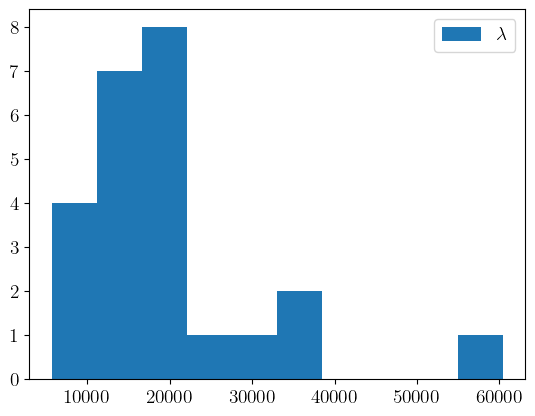

In [131]:
plt.hist(df['true_objective_func'], label='$\lambda$')
plt.legend()

In [132]:
param_names = list(PARAM_DICT.keys())
params = [param_name.split(':')[1] for param_name in param_names]
print(params)
print(len(params))

['aLund', 'bLund', 'aExtraSQuark', 'sigma', 'enhancedFraction', 'ProbStoUD', 'probQQtoQ', 'probSQtoQQ', 'alphaSvalue', 'pTmin']
10


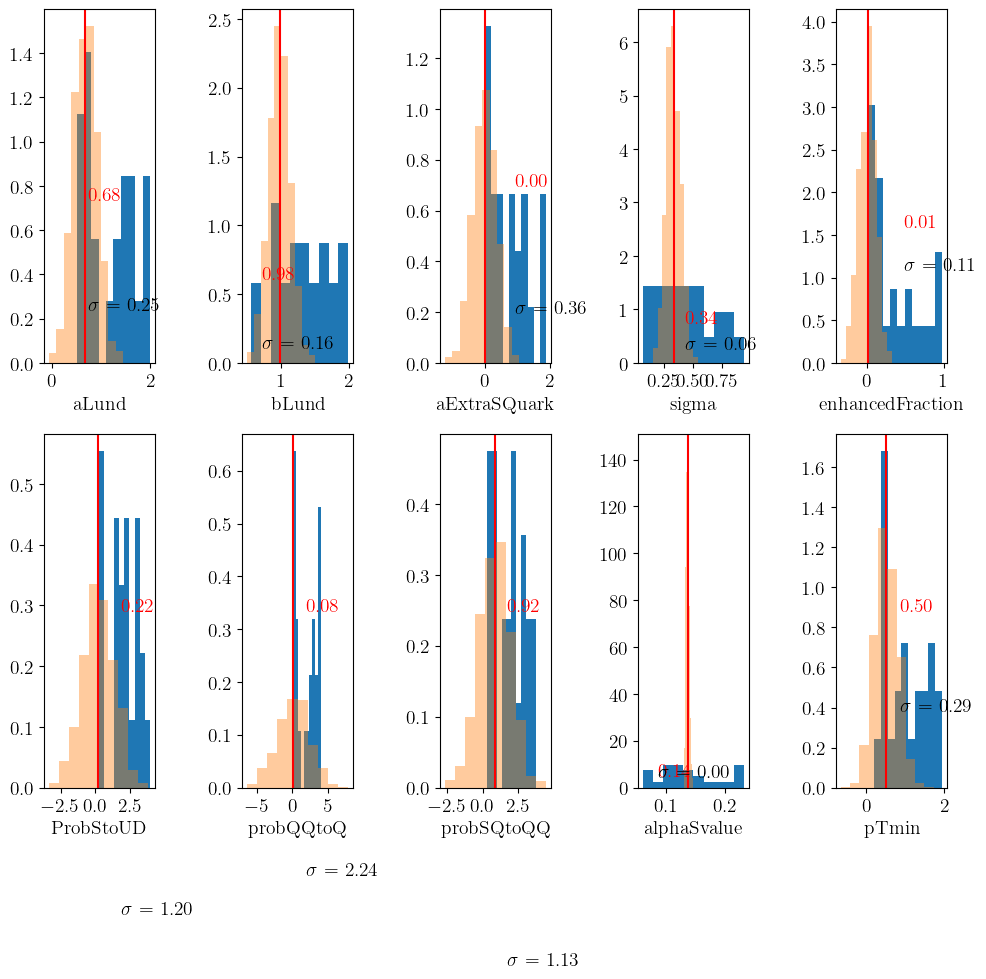

In [133]:
param_vals = [df[param] for param in params]
full_vals = np.stack(param_vals)
full_cov = np.cov(full_vals)

fig, ax = plt.subplots(2,5, figsize=(10,10))
ax = ax.ravel()
stds = np.diagonal(full_cov)
for i, param in enumerate(params):
    vals = df[param].values
    std2 = stds[i]
    ax[i].hist(vals, density=True)
    ax[i].set_xlabel(param)
    best_param = best_parameters_reduced[param]
    ax[i].axvline(x=best_param, color = 'r')
    x_pos = (vals.max() - vals.min())/2
    y_pos = (ax[i].get_ylim()[1] - ax[i].get_ylim()[0])/2
    ax[i].text(y=y_pos, x=x_pos, s=f'{best_param:.2f}', color='r')
    ax[i].text(y=y_pos - 0.5, x=x_pos, s=f'$\sigma$ = {std2:.2f}', color='k')
    gauss = np.random.normal(best_param, std2, size=1000)
    ax[i].hist(gauss, density=True, alpha=0.4)
plt.tight_layout()

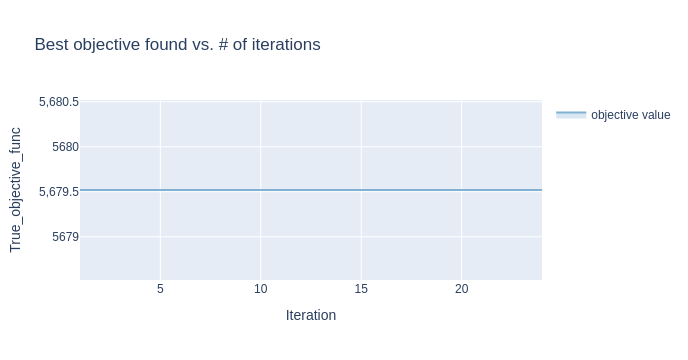

In [134]:
render(ax_client.get_optimization_trace())

[INFO 06-05 18:43:20] ax.service.ax_client: Retrieving contour plot with parameter 'aLund' on X-axis and 'bLund' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


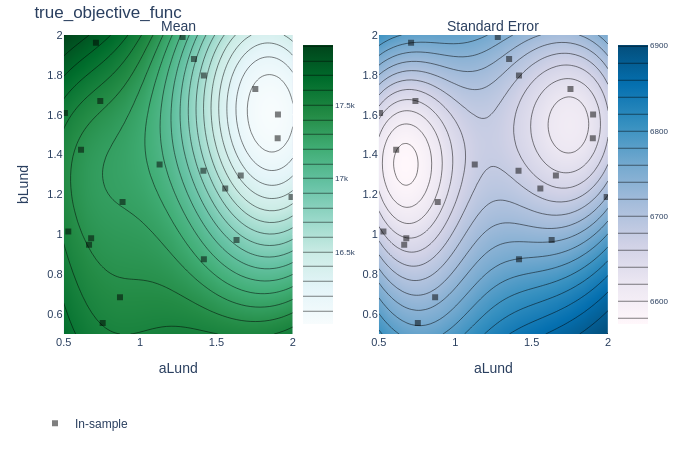

In [135]:
import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(
render(ax_client.get_contour_plot(param_x="aLund", param_y="bLund",))
# )


# fig.show()
# fig.write_image("images/Lund_a_b_countour.pdf")

[INFO 06-05 18:43:25] ax.service.ax_client: Retrieving contour plot with parameter 'aLund' on X-axis and 'sigma' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


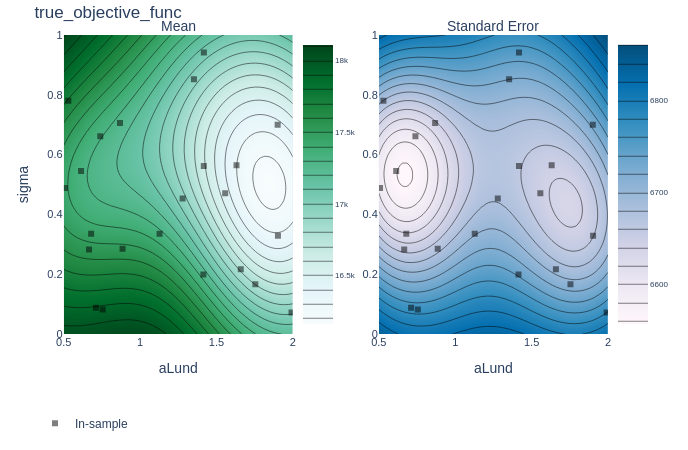

In [136]:
render(ax_client.get_contour_plot(param_x="aLund", param_y="sigma",))

[INFO 06-05 18:43:27] ax.service.ax_client: Retrieving contour plot with parameter 'aExtraSQuark' on X-axis and 'sigma' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


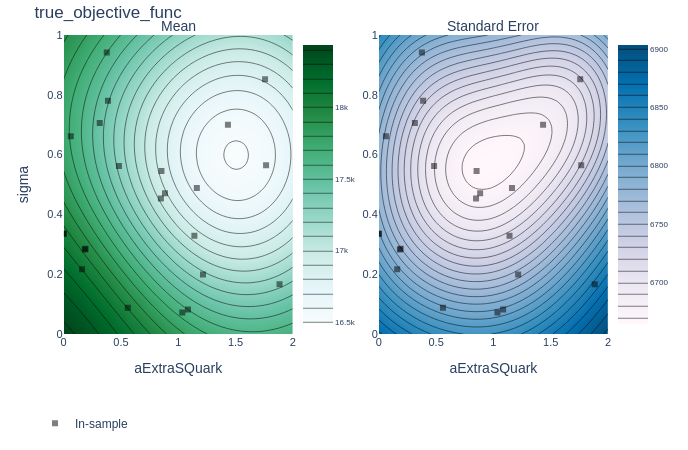

In [137]:
render(ax_client.get_contour_plot(param_x="aExtraSQuark", param_y="sigma",))

In [138]:
render(ax_client.get_contour_plot(param_x="ProbQQ1toQQ0", param_y="sigma",))

ValueError: Parameter "ProbQQ1toQQ0" not found in the optimization search space.

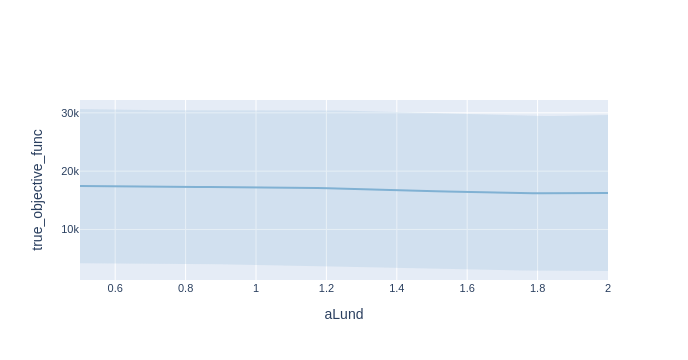

In [139]:
from ax.plot.slice import plot_slice

model = ax_client.generation_strategy.model
render(plot_slice(model, "aLund", "true_objective_func"))

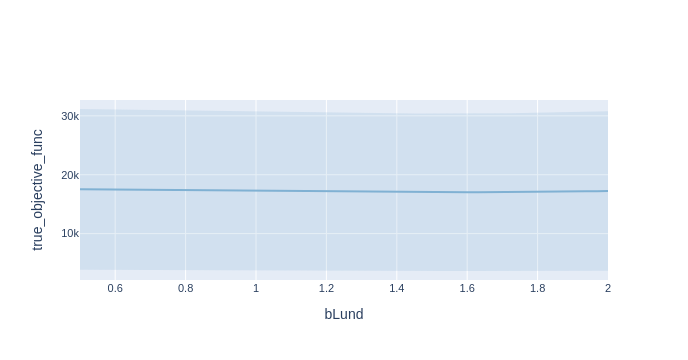

In [140]:
render(plot_slice(model, "bLund", "true_objective_func"))

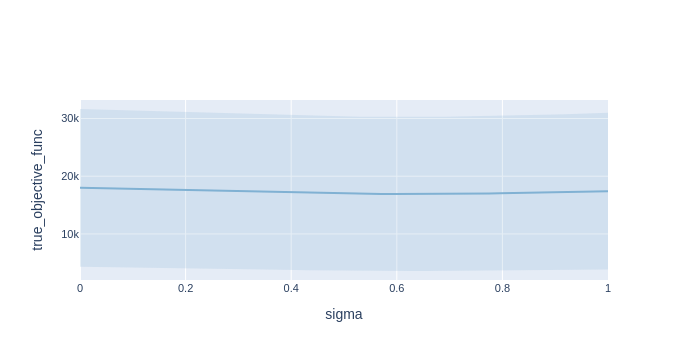

In [141]:
render(plot_slice(model, "sigma", "true_objective_func"))

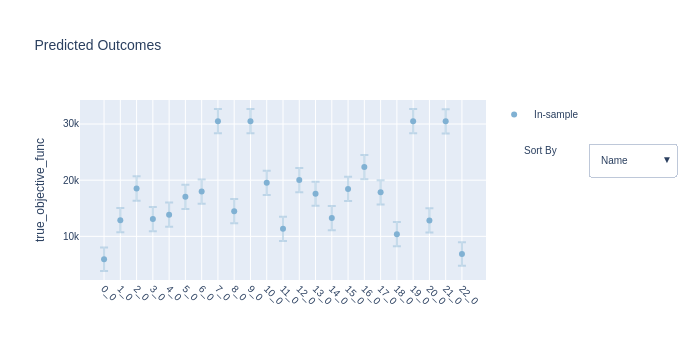

In [142]:
from ax.plot.scatter import plot_fitted
render(plot_fitted(model, metric="true_objective_func", rel=False))

In [143]:
ax_client.get_best_trial()

[WARNING 06-05 18:43:41] ax.modelbridge.cross_validation: Metric true_objective_func was unable to be reliably fit.
[WARNING 06-05 18:43:41] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 06-05 18:43:41] ax.service.utils.best_point: Model fit is poor and data on objective metric true_objective_func is noisy; interpret best points results carefully.


(0,
 {'aLund': 0.68,
  'bLund': 0.98,
  'aExtraSQuark': 0.0,
  'sigma': 0.335,
  'enhancedFraction': 0.01,
  'ProbStoUD': 0.217,
  'probQQtoQ': 0.081,
  'probSQtoQQ': 0.915,
  'alphaSvalue': 0.1365,
  'pTmin': 0.5},
 ({'true_objective_func': 5679.519525051117},
  {'true_objective_func': {'true_objective_func': nan}}))

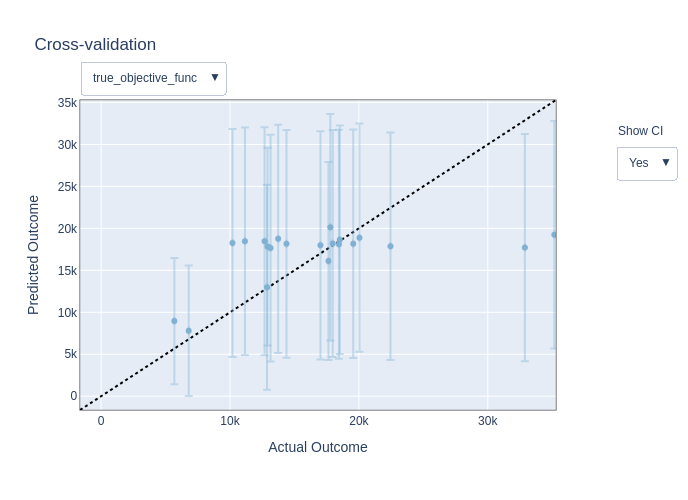

In [144]:
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation

cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))

----

## Validate the results

1. Make the pythia card with the best parameters based on the Bayesian Optimization above
2. Run the pythia card with 300,000 events yielding a test.yoda validation output
3. convert yoda histograms to pandas dataframes, filter histograms and plot result agreement with data

In [145]:
def make_pythia_valid_card(best_parameters):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card_valid.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 3000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")

        f.write("StringZ:aLund = {}\n\n".format(best_parameters["aLund"]))
        f.write("StringZ:bLund = {}\n\n".format(best_parameters["bLund"]))
        # f.write("StringZ:rFactC = {}\n\n".format(best_parameters["rFactC"]))
        # f.write("StringZ:rFactB = {}\n\n".format(best_parameters["rFactB"]))
        f.write("StringZ:aExtraSQuark = {}\n\n".format(best_parameters["aExtraSQuark"]))
        # f.write("StringZ:aExtraDiquark = {}\n\n".format(best_parameters["aExtraDiquark"]))
        f.write("StringPT:sigma = {}\n\n".format(best_parameters["sigma"]))
        f.write("StringPT:enhancedFraction = {}\n\n".format(best_parameters["enhancedFraction"]))
        # f.write("StringPT:enhancedWidth = {}\n\n".format(best_parameters["enhancedWidth"]))
        f.write("StringFlav:ProbStoUD = {}\n\n".format(best_parameters["ProbStoUD"]))
        f.write("StringFlav:probQQtoQ = {}\n\n".format(best_parameters["probQQtoQ"]))
        f.write("StringFlav:probSQtoQQ = {}\n\n".format(best_parameters["probSQtoQQ"]))
        # f.write("StringFlav:ProbQQ1toQQ0 = {}\n\n".format(best_parameters["ProbQQ1toQQ0"]))
        f.write("TimeShower:alphaSvalue = {}\n\n".format(best_parameters["alphaSvalue"]))
        f.write("TimeShower:pTmin = {}\n\n".format(best_parameters["pTmin"]))
def run_valid_card(best_parameters):
    
    # step 1: write .cmnd file 
    make_pythia_valid_card(best_parameters)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    rivet -o ALEPH_1996_S3486095_hist_valid_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    mv ALEPH_1996_S3486095_hist_valid_0.yoda ALEPH_YODAS_BayesOpt/""")

In [109]:
run_valid_card(best_parameters_reduced)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |

Rivet 3.1.9 running on machine cf9fd2c43a7b (x86_64) at 2024-06-05 18:33:17
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)
Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:03 elapsed)






Rivet.AnalysisHandler: INFO  Using named weights


Event 3000 (0:00:03 elapsed)
Finished event loop at 2024-06-05 18:33:20
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-05 18:33:20, time elapsed = 0:00:03
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_valid_0.yoda


In [146]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy

def get_valid_data():
    # tracemalloc.start()
    yoda2numpy = Yoda2Numpy()
    files = list(glob('ALEPH_YODAS_BayesOpt/*.yoda'))
    M = len(files)
    # M = 
    generated_indices = []
    for file in files[:M]:
        index = file.split('_')[-1].split('.')[0]
        generated_indices.append(int(index))    
    generated_indices.sort()
    print(generated_indices)
    # # --- SIM
    print(f'looping over {M:d} sim yoda files...\n')
    # dfsims = []
    dfsims_valid = {}
    for ii in tqdm(generated_indices):    
        # index here should match the index of the file
        # dfsims.append( yoda2numpy.todf( yoda2numpy('sim', index=ii) ) )
        dfsims_valid[ii]= yoda2numpy.todf( yoda2numpy('val', index=ii) ) 

    # # --- NEW
    # print(f'looping over {M:d} new yoda files...\n')
    # # dfnews = []
    # # for ii in tqdm(range(M)):
    # #     dfnews.append( yoda2numpy.todf( yoda2numpy('new', index=ii) ) )

    print()
    # key = '/ALEPH_1996_S3486095/d01-x01-y01'
    # dfsim = dfsims[0][key]
    
    dfdata = yoda2numpy.todf( yoda2numpy('dat') )
    
    return dfdata, dfsims_valid, generated_indices

In [147]:
dfdata, dfsims_valid, generated_indices = get_valid_data()

[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.55it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_valid_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_valid_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


In [148]:
print(generated_indices)
# print(dfsims)
print('DATA DATAFRAME')
print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
print('FIRST SIM-VALID DATAFRAME')
print(dfsims_valid[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

[0, 0]
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM-VALID DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.333334  0.822222  0.044134  0.034067       185.0
1  0.005  0.010  23.000000  1.533333  0.171386  0.265132       345.0
2  0.010  0.015  19.866667  1.324444  0.244138  0.608062       298.0
3  0.015  0.020  16.600000  1.106667  0.290574  1.024069       249.0
4  0.020  0.025  12.933334  0.862222  0.292291  1.326500       194.0


In [149]:
data_keys, mc_keys = get_hist_names(dfdata)
filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims_valid, data_keys, mc_keys)

 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

In [150]:
reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)
print(reduced_data_keys, reduced_mc_keys)
print(f'length of reduced data keys = {len(reduced_data_keys)}')
print(f'length of reduced mc keys = {len(reduced_mc_keys)}')

['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S3486095/d37-x01-y01',

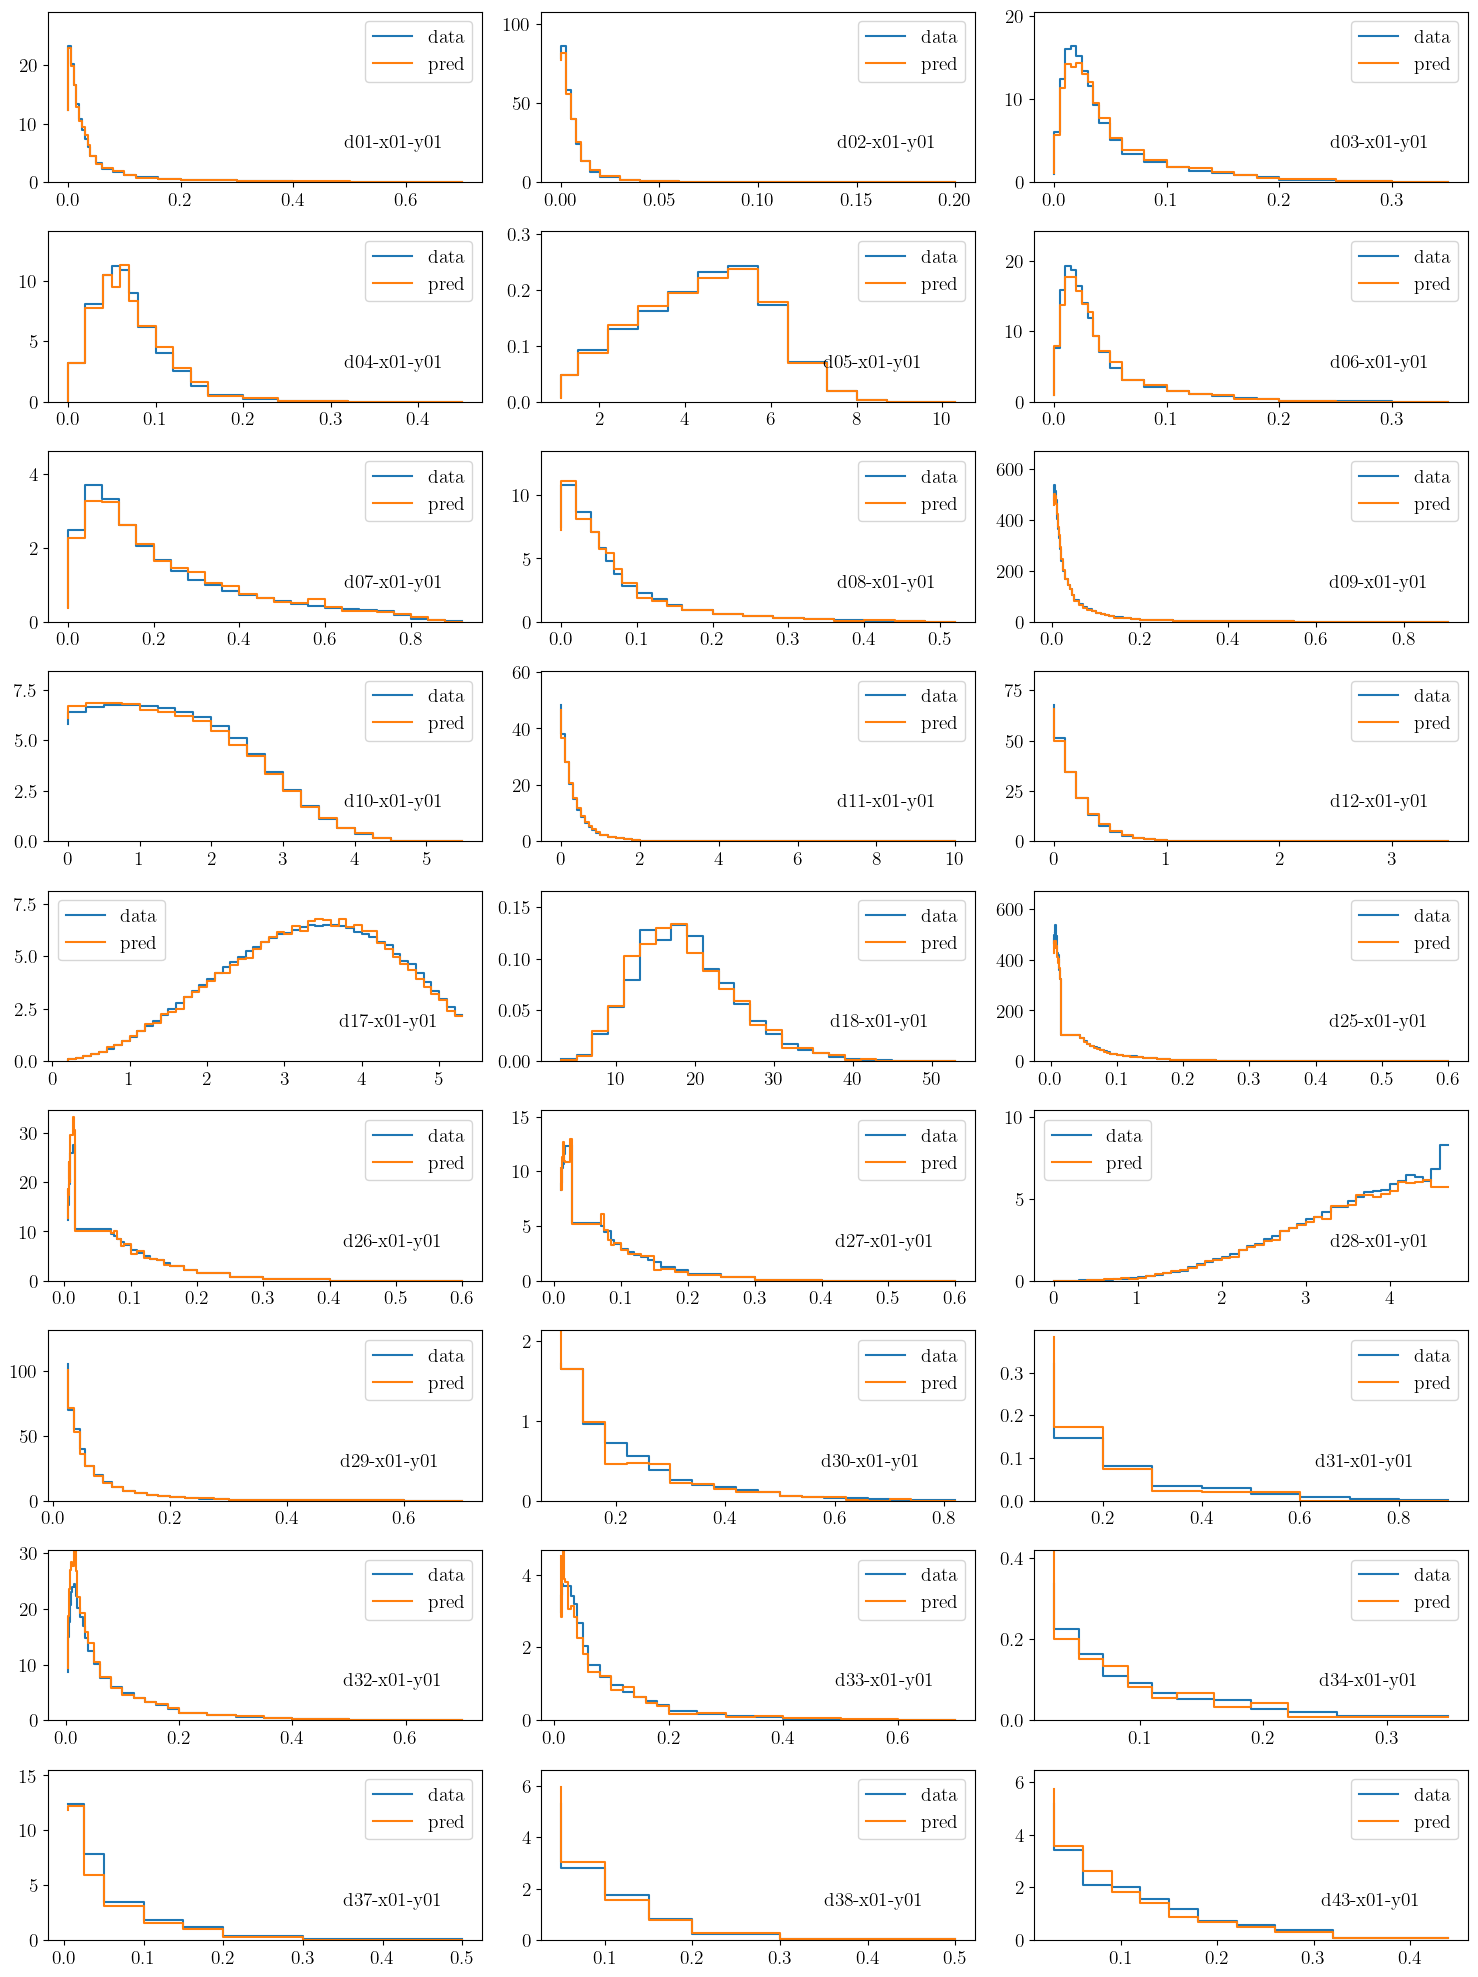

In [155]:
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import * 

hists = make_hists(dfdata, dfsims_valid[0], reduced_data_keys, reduced_mc_keys)

plot_dist(reduced_data_keys, hists, filename=f'images/Ax_BayesianOpt_Valid_Best_fit_hists_reduced_params_{N_ITER}_iter.pdf')

In [153]:
def plot_model_chi2_vs_param(param, reference_dict, ax):
    PARAM_DICT_small = {key.split(':')[1] : val for key,val in PARAM_DICT.items()}
    # param = 'aLund'
    N_points = 1000
    # reference_dict = MONASH_DICT
    aLund_linspace =  np.linspace(PARAM_DICT_small[param][0], PARAM_DICT_small[param][1], N_points)
    aLund_observation_dicts = []
    for val in aLund_linspace:
        new_dict = reference_dict.copy()
        new_dict[param] = val
        aLund_observation_dicts.append(new_dict)
    
    means_a, covs_a = model.predict([
            ObservationFeatures(parameters=pointi) for pointi in aLund_observation_dicts
        ]
    )

    chi2_means = np.array(list(means_a.values())[0])
    chi2_covs = np.array(covs_a['true_objective_func']['true_objective_func'])
    
    ax.plot(aLund_linspace, chi2_means, c='k', linewidth=3)

    ax.set_ylim(0, chi2_means.max())
    ypos = (ax.get_ylim()[1] -ax.get_ylim()[0])/2
    xpos = best_parameters_reduced[param] + 0.05
    ax.text(x= xpos, y=ypos, s= '{:.3f}'.format(best_parameters_reduced[param]), color='r')
    ax.fill_between(x=aLund_linspace, y1=chi2_means-chi2_covs,y2=chi2_means+chi2_covs, alpha=0.3, color='b')
    ax.set_xlabel(param, fontsize=22)
    ax.set_ylabel('GP $\lambda$', fontsize=22)
    ax.scatter(df[param], df['true_objective_func'], color='green')
    ax.axvline(x=best_parameters_reduced[param], color='r')

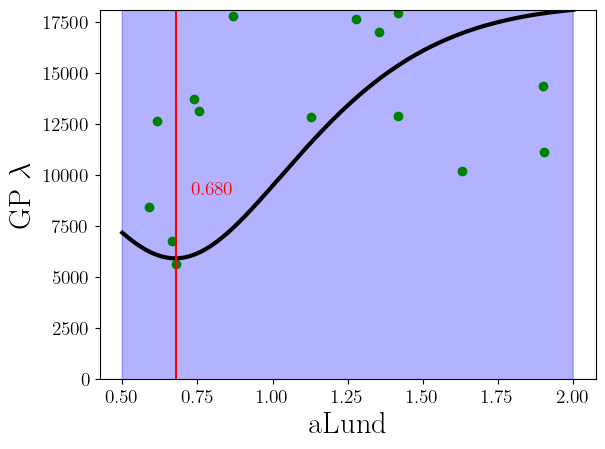

In [154]:
fig, ax = plt.subplots(1,1)
plot_model_chi2_vs_param(param='aLund', reference_dict=best_parameters_reduced, ax=ax)

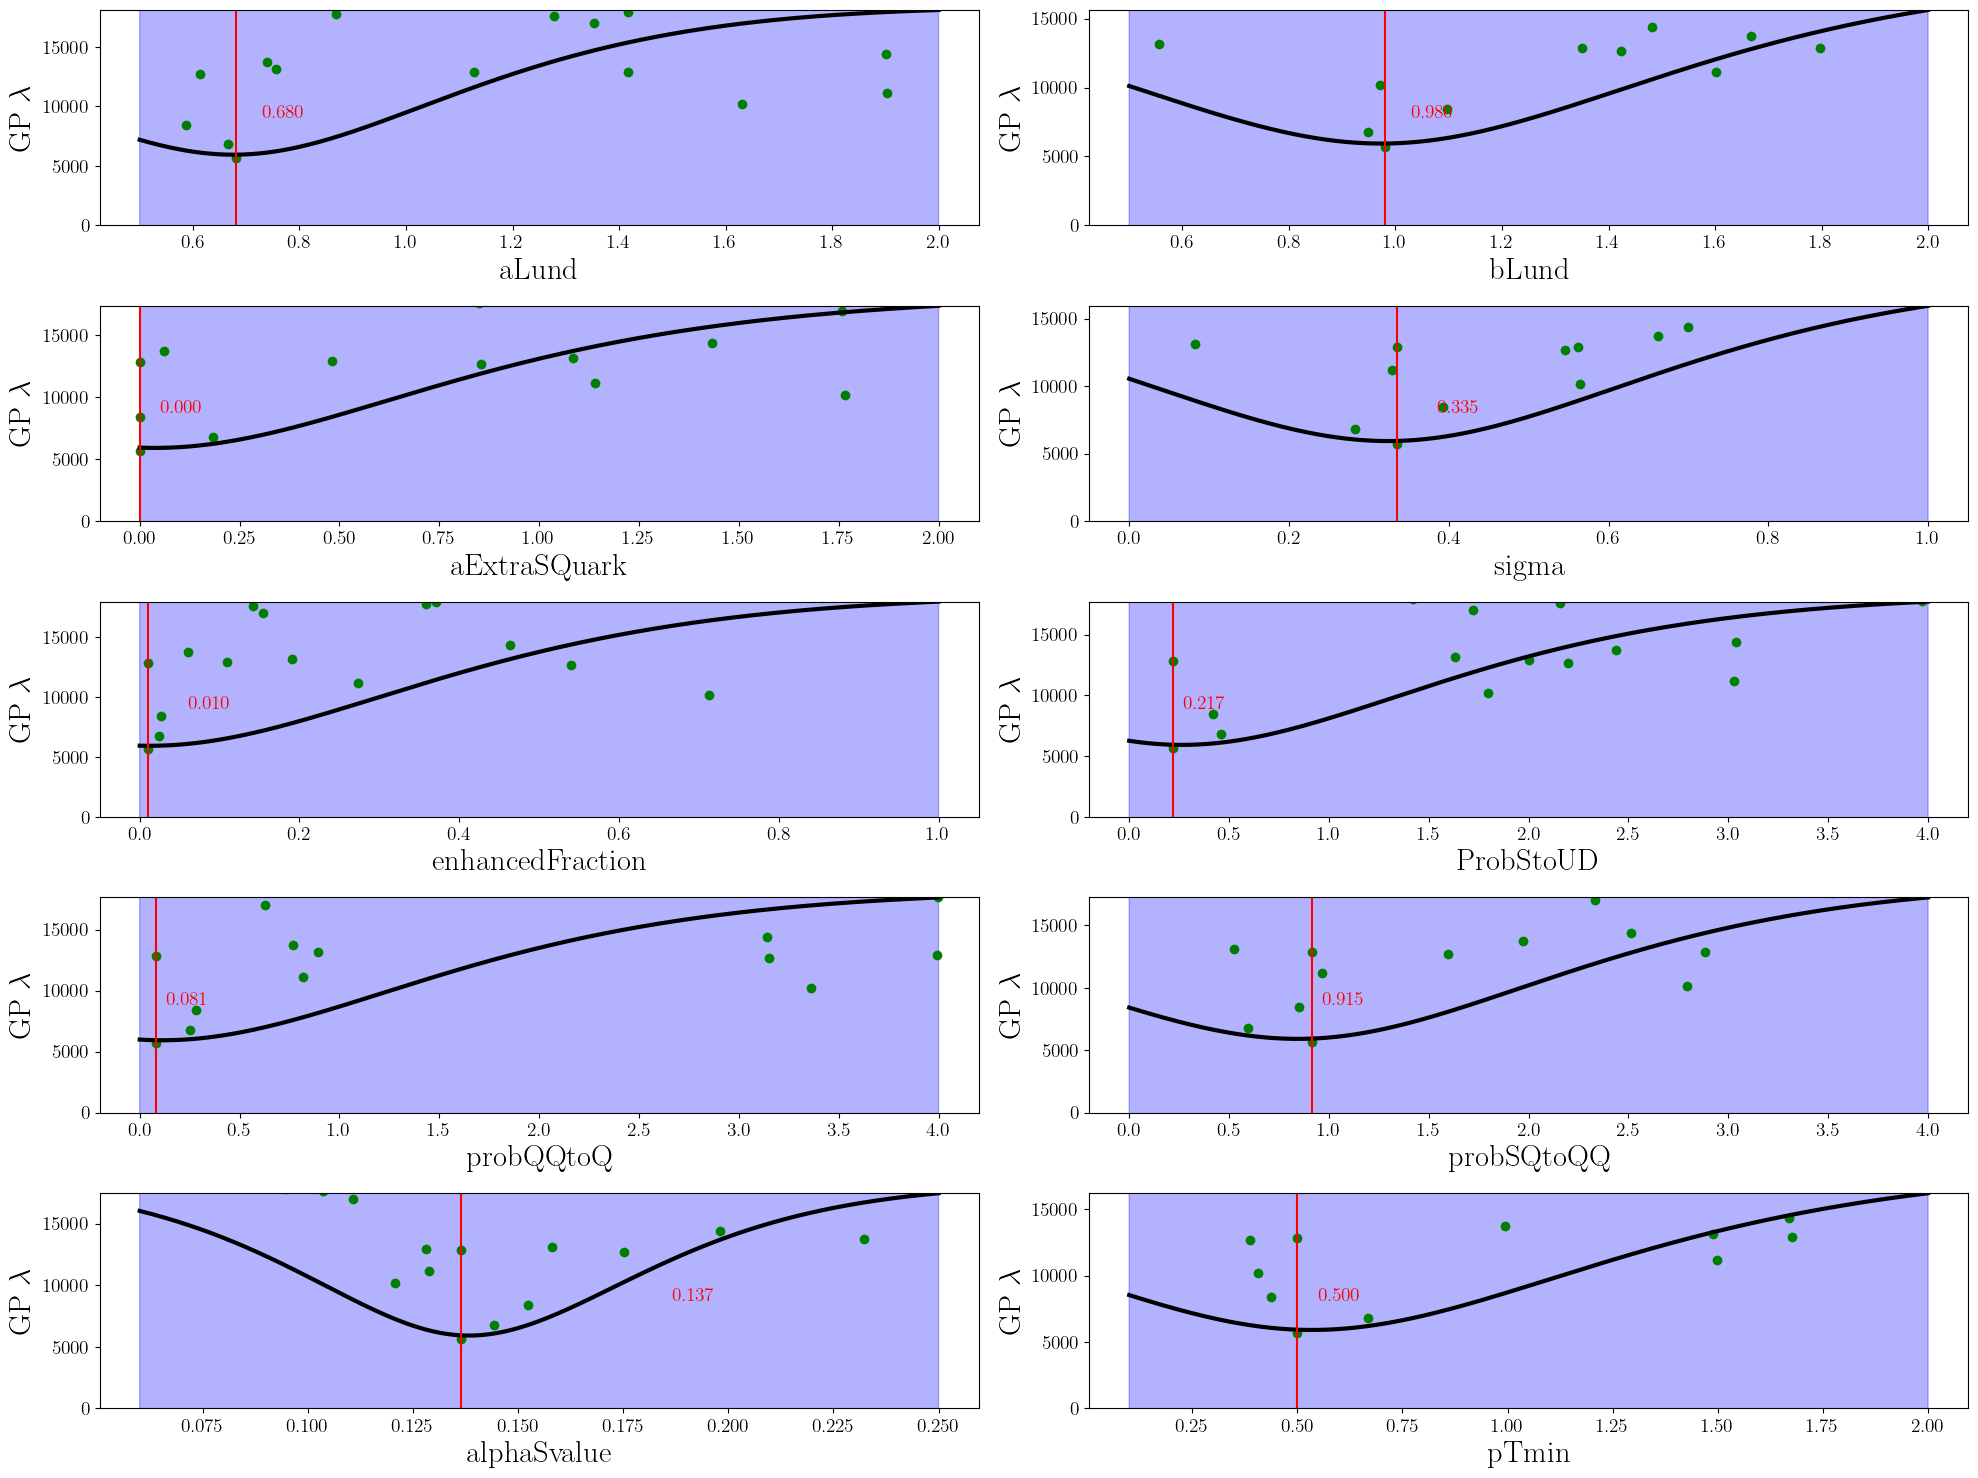

In [157]:
fig, ax = plt.subplots(5, 2, figsize=(20,15))
ax = ax.ravel()
for i, axi in enumerate(ax):
    params = list(REDUCED_MONASH_DICT.keys())
    plot_model_chi2_vs_param(param=params[i], reference_dict=best_parameters_reduced, ax=axi)

plt.tight_layout()
plt.savefig(f'images/GP_lambda_vs_param_all_params.pdf')

# Get profile likelihood of each parameter with Minuit, and the total covariance matrix

In [158]:
import iminuit
from iminuit import Minuit

In [159]:
def cost_func(aLund, 
             bLund,
            aExtraSQuark,
            sigma,
            enhancedFraction,
            ProbStoUD,
            probQQtoQ,
            probSQtoQQ,
            alphaSvalue,
            pTmin):
    
    params_dict = {
    "aLund" : aLund, 
    "bLund" : bLund,
    "aExtraSQuark": aExtraSQuark,
    "sigma":sigma,
    "enhancedFraction":enhancedFraction,
    "ProbStoUD":ProbStoUD,
    "probQQtoQ":probQQtoQ,
    "probSQtoQQ":probSQtoQQ,
    "alphaSvalue": alphaSvalue,
    "pTmin": pTmin
    }
    means, covs = model.predict([
            ObservationFeatures(parameters=params_dict)
        ]
    )
    return means['true_objective_func'][0]

In [160]:
cost_func(**best_parameters_reduced)

5934.875623913371

In [161]:
limits = list(PARAM_DICT.values())

In [163]:
m = Minuit(cost_func, **best_parameters_reduced)
m.limits = limits

In [164]:
m.migrad(ncall=500000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5814                       │              Nfcn = 274              │
│ EDM = 4.57e-07 (Goal: 0.0002)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name             │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ aLund            │   0.676   │   0.005   │            │            │   0.5   │    2    │       │
│ 1 │ bLund            │   0.972   │   0.006   │            │            │   0.5   │    2    │       │
│ 2 │ aExtraSQuark     │   0.043   │   0.008   │            │            │    0    │    2    │       │
│ 3 │ sigma            │   0.323   │   0.004   │            │            │    0    │    1    │       │
│ 4 │ enhancedFraction │   0.013   │   0.004   │            │            │    0    │    1    │       │
│ 5 │ ProbStoUD        │   0.272   │   0.014   │            │            │    0    │    4    │       │
│ 6 │ probQQtoQ        │   0.119   │   0.015   │            │            │    0    │    4    │       │
│ 7 │ probSQtoQQ       │   0.836   │   0.015   │            │            │    0    │    4    │       │
│ 8 │ alphaSvalue      │ 138.5e-3  │  0.5e-3   │            │            │  0.06   │  0.25   │       │
│ 9 │ pTmin            │   0.539   │   0.008   │            │            │   0.1   │    2    │       │
└───┴──────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                  │            aLund            bLund     aExtraSQuark            sigma enhancedFraction        ProbStoUD        probQQtoQ       probSQtoQQ      alphaSvalue            pTmin │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            aLund │         2.19e-05                0               -0                0               -0               -0               -0               -0         -0.03e-6               -0 │
│            bLund │                0         3.67e-05               -0                0               -0               -0               -0                0         -0.01e-6               -0 │
│     aExtraSQuark │               -0               -0         6.21e-05        -0.001e-3                0                0                0               -0          0.09e-6                0 │
│            sigma │                0                0        -0.001e-3         1.49e-05               -0        -0.001e-3        -0.001e-3         0.001e-3         -0.02e-6        -0.001e-3 │
│ enhancedFraction │               -0               -0                0               -0         1.43e-05                0                0               -0          0.02e-6                0 │
│        ProbStoUD │               -0               -0                0        -0.001e-3              

In [165]:
best_parameters_reduced

{'aLund': 0.68,
 'bLund': 0.98,
 'aExtraSQuark': 0.0,
 'sigma': 0.335,
 'enhancedFraction': 0.01,
 'ProbStoUD': 0.217,
 'probQQtoQ': 0.081,
 'probSQtoQQ': 0.915,
 'alphaSvalue': 0.1365,
 'pTmin': 0.5}

In [166]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5814                       │             Nfcn = 1059              │
│ EDM = 4.57e-07 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name             │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ aLund            │   0.676   │   0.005   │   -0.005   │   0.005    │   0.5   │    2    │       │
│ 1 │ bLund            │   0.972   │   0.006   │   -0.006   │   0.006    │   0.5   │    2    │       │
│ 2 │ aExtraSQuark     │   0.043   │   0.008   │   -0.008   │   0.008    │    0    │    2    │       │
│ 3 │ sigma            │   0.323   │   0.004   │   -0.004   │   0.004    │    0    │    1    │       │
│ 4 │ enhancedFraction │   0.013   │   0.004   │   -0.004   │   0.004    │    0    │    1    │       │
│ 5 │ ProbStoUD        │   0.272   │   0.014   │   -0.014   │   0.014    │    0    │    4    │       │
│ 6 │ probQQtoQ        │   0.119   │   0.015   │   -0.015   │   0.015    │    0    │    4    │       │
│ 7 │ probSQtoQQ       │   0.836   │   0.015   │   -0.015   │   0.015    │    0    │    4    │       │
│ 8 │ alphaSvalue      │ 138.5e-3  │  0.5e-3   │  -0.5e-3   │   0.5e-3   │  0.06   │  0.25   │       │
│ 9 │ pTmin            │   0.539   │   0.008   │   -0.008   │   0.008    │   0.1   │    2    │       │
└───┴──────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         aLund         │         bLund         │     aExtraSQuark      │         sigma         │   enhancedFraction    │       ProbStoUD       │       probQQtoQ       │      probSQtoQQ       │      alphaSvalue      │         pTmin         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.005   │   0.005   │  -0.006   │   0.006   │  -0.008   │   0.008   │  -0.004   │   0.004   │  -0.004   │   0.004   │  -0.014   │   0.014   │  -0.015   │   0.015   │  -0.015   │   0.015   │  -0.5e-3  │  0.5e-3   │  -0.008   │   0.008   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False

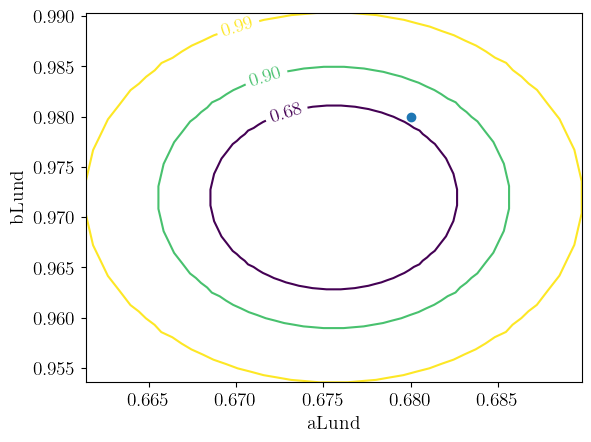

In [167]:
m.draw_mncontour('aLund','bLund', cl=(0.68, 0.9, 0.99))
plt.scatter(best_parameters_reduced['aLund'], best_parameters_reduced['bLund'])

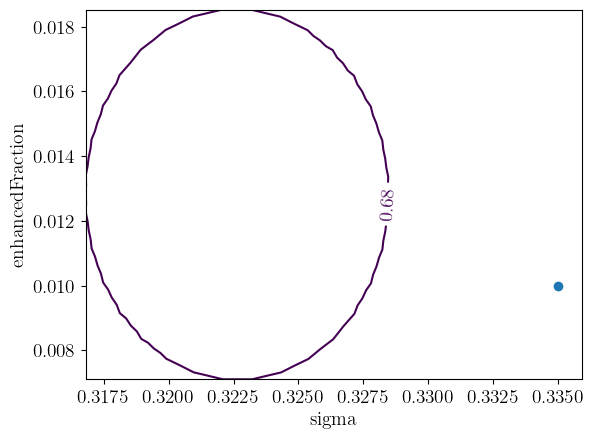

In [170]:
m.draw_mncontour('sigma','enhancedFraction')
plt.scatter(best_parameters_reduced['sigma'], best_parameters_reduced['enhancedFraction'])

(array([0.66624307, 0.66688849, 0.66753391, 0.66817933, 0.66882475,
        0.66947017, 0.67011559, 0.67076101, 0.67140643, 0.67205185,
        0.67269727, 0.67334269, 0.6739881 , 0.67463352, 0.67527894,
        0.67592436, 0.67656978, 0.6772152 , 0.67786062, 0.67850604,
        0.67915146, 0.67979688, 0.6804423 , 0.68108772, 0.68173314,
        0.68237856, 0.68302398, 0.6836694 , 0.68431482, 0.68496024]),
 array([3.99173452e+00, 3.45976724e+00, 2.96572960e+00, 2.50963533e+00,
        2.09149733e+00, 1.71132778e+00, 1.36913805e+00, 1.06493873e+00,
        7.98739626e-01, 5.70549773e-01, 3.80377407e-01, 2.28229980e-01,
        1.14114155e-01, 3.80358021e-02, 0.00000000e+00, 1.10330711e-05,
        3.80723938e-02, 1.14186776e-01, 2.28356078e-01, 3.80581405e-01,
        5.70863060e-01, 7.99200551e-01, 1.06559259e+00, 1.37003709e+00,
        1.71253116e+00, 2.09307112e+00, 2.51165249e+00, 2.96827000e+00,
        3.46291756e+00, 3.99558832e+00]))

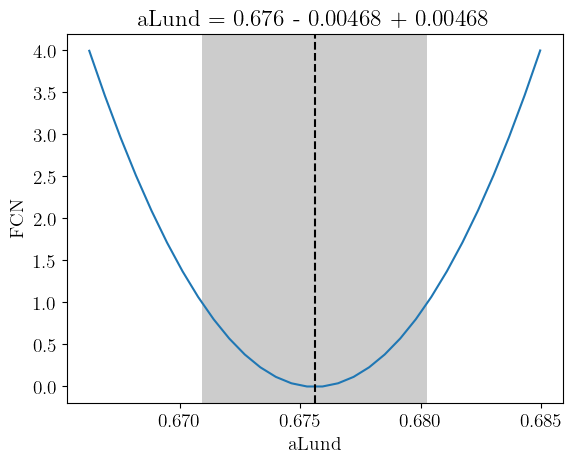

In [171]:
m.draw_mnprofile("aLund")

In [172]:
covariance = m.covariance
covariance

┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                  │            aLund            bLund     aExtraSQuark            sigma enhancedFraction        ProbStoUD        probQQtoQ       probSQtoQQ      alphaSvalue            pTmin │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            aLund │         2.19e-05                0               -0                0               -0               -0               -0               -0         -0.03e-6               -0 │
│            bLund │                0         3.67e-05               -0                0               -0               -0               -0                0         -0.01e-6               -0 │
│     aExtraSQuark │               -0               -0         6.21e-05        -0.001e-3                0                0                0               -0          0.09e-6                0 │
│            sigma │                0                0        -0.001e-3         1.49e-05               -0        -0.001e-3        -0.001e-3         0.001e-3         -0.02e-6        -0.001e-3 │
│ enhancedFraction │               -0               -0                0               -0         1.43e-05                0                0               -0          0.02e-6                0 │
│        ProbStoUD │               -0               -0                0        -0.001e-3                0         0.000203                0         -0.01e-3          0.20e-6                0 │
│        probQQtoQ │               -0               -0                0        -0.001e-3                0                0         0.000222               -0          0.17e-6                0 │
│       probSQtoQQ │               -0                0               -0         0.001e-3               -0         -0.01e-3               -0         0.000225         -0.14e-6               -0 │
│      alphaSvalue │         -0.03e-6         -0.01e-6          0.09e-6         -0.02e-6          0.02e-6          0.20e-6          0.17e-6         -0.14e-6          2.1e-07          0.10e-6 │
│            pTmin │               -0               -0                0        -0.001e-3                0                0                0               -0          0.10e-6          5.9e-05 │
└──────────────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [173]:
covariance.correlation()

┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                  │            aLund            bLund     aExtraSQuark            sigma enhancedFraction        ProbStoUD        probQQtoQ       probSQtoQQ      alphaSvalue            pTmin │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            aLund │                1                0                0                0                0                0                0                0                0                0 │
│            bLund │                0                1                0                0                0                0                0                0                0                0 │
│     aExtraSQuark │                0                0                1                0                0                0                0                0                0                0 │
│            sigma │                0                0                0                1                0                0                0                0                0                0 │
│ enhancedFraction │                0                0                0                0                1                0                0                0                0                0 │
│        ProbStoUD │                0                0                0                0                0                1                0                0                0                0 │
│        probQQtoQ │                0                0                0                0                0                0                1                0                0                0 │
│       probSQtoQQ │                0                0                0                0                0                0                0                1                0                0 │
│      alphaSvalue │                0                0                0                0                0                0                0                0                1                0 │
│            pTmin │                0                0                0                0                0                0                0                0                0                1 │
└──────────────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘